# Прогнозирование смертности от рака почек

* Работу выполнили команда last minute
* Капитан команды Анна Антипова

# Содержание

1. [IMPORT, FUNCTIONS, SETUP](#1)
2. [DATA & PRELIMINARY ANALYSIS](#2)
3. [EDA](#3) 
4. [MODEL](#4)
5. [SUMMARY](#7)

<a id="1"></a>
# 1. Import, Functions, Setup

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import balanced_accuracy_score

pd.set_option('display.max_columns', 120)
%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1
Pandas       : 1.0.5


In [3]:
# подключила к ноутбуку внешний датасет
path = 'C:/Users/Ludmila/Notebooks (PY)/BEST_HACK2022/TASK2_DT'
VAL_SIZE = 0.20   # 20%

In [4]:
def missing_value(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также процент пропуска
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

In [5]:
test = pd.read_excel(path + '/data/Test_unlabled.xlsx',engine='openpyxl')
df = pd.read_excel(path + '/data/Train_labled.xlsx',engine='openpyxl')

In [6]:
# удалим ненужные (индексные) столбцы
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], 1, inplace=True)
test.drop('Unnamed: 0', 1, inplace=True)

In [7]:
# Типы данных и количество уникальных значений каждой переменной в обучающем датасете
data = {'Тип переменной':df.dtypes, 'Кол-во уникальных значений':df.nunique()}
pd.DataFrame(data, columns=['Тип переменной', 'Кол-во уникальных значений']).transpose()

Возраст    Пол Вес, кг Рост, см рост2, м2  \
Тип переменной               int64  int64   int64    int64   float64   
Кол-во уникальных значений      49      2      57       39        39   

                           BMI, кг/м2 Болезни, влияющие на ф-цию почек  \
Тип переменной                float64                            int64   
Кол-во уникальных значений        212                                2   

                           Charlson Comorbidity Index,  Comorbidity Component  \
Тип переменной                                  float64                 int64   
Кол-во уникальных значений                           10                     3   

                           1. Scoring: Age ASA (в осмотре анестезиологом)  \
Тип переменной                       int64                          int64   
Кол-во уникальных значений               5                              3   

                           Сторона поражения  \
Тип переменной                         int64   
Кол-во уникальных значений                 2   

                           d max при одностороннем поражении локализация  \
Тип переменной                                       float64     float64   
Кол-во уникальных значений                               126           5   

                           локализация.1  кисты  RENAL  \
Тип переменной                     int64  int64  int64   
Кол-во уникальных значений             3      2      8   

                           RENAL риск (4-6 vs 7-9 vs >=10) Размер  \
Тип переменной                                       int64  int64   
Кол-во уникальных значений                               3      3   

                           Экзофит >50% - <50% - эндофит  \
Тип переменной                                     int64   
Кол-во уникальных значений                             3   

                           синус/члс >7, 4-7, <=4 мм Polar lines  PADUA  \
Тип переменной                                 int64       int64  int64   
Кол-во уникальных значений                         3           3      8   

                           PADUA риск (6-7 vs 8-9 vs >=10) Longitudinal  \
Тип переменной                                       int64        int64   
Кол-во уникальных значений                               3            2   

                           Exophitic Renal rim  Sinus    ЧЛС Размер.1  \
Тип переменной                 int64     int64  int64  int64    int64   
Кол-во уникальных значений         3         2      2      2        3   

                           Показания к резекции  \
Тип переменной                            int64   
Кол-во уникальных значений                    4   

                           Единственная почка не из-за рака  \
Тип переменной                                        int64   
Кол-во уникальных значений                                2   

                           Нефункционирующая вторая почка не из-за рака  \
Тип переменной                                                    int64   
Кол-во уникальных значений                                            2   

                           Нормальная вторая почка Аномальная почка  \
Тип переменной                               int64            int64   
Кол-во уникальных значений                       2                3   

                           Исходный диагноз Доступ первой резекции  \
Тип переменной                        int64                  int64   
Кол-во уникальных значений                2                      2   

                           Доступ первой резекции.1 Ишемия да-нет  \
Тип переменной                                int64         int64   
Кол-во уникальных значений                        2             2   

                           Что пережимали Тепловая-холодовая ишемия  \
Тип переменной                    float64                   float64   
Кол-во уникальных значений             73                        72   

                           Время ишемии УЗИ интраоперационное Находки при УЗИ  \
Тип

In [8]:
# Типы данных и количество уникальных значений каждой переменной в тестовом датасете
data1 = {'Тип переменной':test.dtypes, 'Кол-во уникальных значений':test.nunique()}
pd.DataFrame(data1, columns=['Тип переменной', 'Кол-во уникальных значений']).transpose()

Возраст    Пол Вес, кг Рост, см рост2, м2  \
Тип переменной               int64  int64   int64    int64   float64   
Кол-во уникальных значений      41      2      48       33        33   

                           BMI, кг/м2 Болезни, влияющие на ф-цию почек  \
Тип переменной                float64                            int64   
Кол-во уникальных значений         93                                2   

                           Charlson Comorbidity Index,  Comorbidity Component  \
Тип переменной                                  float64                 int64   
Кол-во уникальных значений                            9                     2   

                           1. Scoring: Age ASA (в осмотре анестезиологом)  \
Тип переменной                       int64                          int64   
Кол-во уникальных значений               5                              3   

                           Сторона поражения  \
Тип переменной                         int64   
Кол-во уникальных значений                 2   

                           d max при одностороннем поражении локализация  \
Тип переменной                                       float64     float64   
Кол-во уникальных значений                                65           4   

                           локализация.1  кисты  RENAL  \
Тип переменной                     int64  int64  int64   
Кол-во уникальных значений             3      2      8   

                           RENAL риск (4-6 vs 7-9 vs >=10) Размер  \
Тип переменной                                       int64  int64   
Кол-во уникальных значений                               3      3   

                           Экзофит >50% - <50% - эндофит  \
Тип переменной                                     int64   
Кол-во уникальных значений                             3   

                           синус/члс >7, 4-7, <=4 мм Polar lines  PADUA  \
Тип переменной                                 int64       int64  int64   
Кол-во уникальных значений                         3           3      8   

                           PADUA риск (6-7 vs 8-9 vs >=10) Longitudinal  \
Тип переменной                                       int64        int64   
Кол-во уникальных значений                               3            2   

                           Exophitic Renal rim  Sinus    ЧЛС Размер.1  \
Тип переменной                 int64     int64  int64  int64    int64   
Кол-во уникальных значений         3         2      2      2        3   

                           Показания к резекции  \
Тип переменной                            int64   
Кол-во уникальных значений                    4   

                           Единственная почка не из-за рака  \
Тип переменной                                        int64   
Кол-во уникальных значений                                2   

                           Нефункционирующая вторая почка не из-за рака  \
Тип переменной                                                    int64   
Кол-во уникальных значений                                            2   

                           Нормальная вторая почка Аномальная почка  \
Тип переменной                               int64            int64   
Кол-во уникальных значений                       2                3   

                           Исходный диагноз Доступ первой резекции  \
Тип переменной                        int64                  int64   
Кол-во уникальных значений                2                      2   

                           Доступ первой резекции.1 Ишемия да-нет  \
Тип переменной                                int64         int64   
Кол-во уникальных значений                        2             2   

                           Что пережимали Тепловая-холодовая ишемия  \
Тип переменной                    float64                   float64   
Кол-во уникальных значений             34                        33   

                           Время ишемии УЗИ интраоперационное Находки при УЗИ  \
Тип

In [9]:
# сравним данные из обоих датасетов с одним значением признака
df_one = [df[i].unique() for i in ['рN', 'M', 'эффект']]
test_one = [test[i].unique() for i in ['рN', 'M', 'эффект']]
pd.DataFrame({'df': df_one, ' test': test_one}, index=['рN', 'M', 'эффект'])

df        test
рN      [0.0, nan]  [0.0, nan]
M       [0.0, nan]  [0.0, nan]
эффект         [1]         [1]

In [10]:
# удалим признаки, не несущие полезной информации,: 'рN', 'M', 'эффект'
df.drop(['рN', 'M', 'эффект'], 1, inplace=True)
test.drop(['рN', 'M', 'эффект'], 1, inplace=True)

In [11]:
# переименуем столбец в датасетах
df.rename({'Charlson Comorbidity Index, ': 'Charlson Comorbidity Index'}, axis=1, inplace=True)
test.rename({'Charlson Comorbidity Index, ': 'Charlson Comorbidity Index'}, axis=1, inplace=True)

***Проверим, какие данные из датасетов являются бинарными***

In [12]:
df_bcol = [col for col in df.columns if df[col].nunique() <= 2]
test_bcol = [col for col in test.columns if test[col].nunique() <= 2]
print(f'Кол-во переменных в обучении  {len(df_bcol)}, Кол-во переменных в тесте  {len(test_bcol)}')

Кол-во переменных в обучении  48, Кол-во переменных в тесте  51


In [13]:
# Список колонок, которых нет в обучающем наборе
dif_list = list(set(test_bcol).difference(df_bcol))
print(f'Список колонок, которых нет в обучающем наборе, но есть в test:\n{dif_list}')

# Посмотрим на количество данные в этих колонках
s1 = [test[i].unique() for i in dif_list]
s = [df[i].unique() for i in dif_list]
#pd.DataFrame({'test':test[dif_list].nunique(), 'df':df[dif_list].nunique()})
pd.DataFrame({'test':s1, 'df':s}, index=dif_list)

Список колонок, которых нет в обучающем наборе, но есть в test:
['Comorbidity Component', 'pT при одностороннем поражении.1', 'Осложнения интраоперационные.1']


test                    df
Comorbidity Component                      [2, 3]             [2, 3, 4]
pT при одностороннем поражении.1  [1.0, nan, 3.0]  [1.0, nan, 3.0, 2.0]
Осложнения интраоперационные.1             [0, 1]             [1, 0, 2]

In [14]:
# удалим данные признаки из списка бинарных признаков
test_bcol.remove('Осложнения интраоперационные.1')
test_bcol.remove('Comorbidity Component')
test_bcol.remove('pT при одностороннем поражении.1')
len(test_bcol)

48

In [15]:
df_one = [df[i].unique() for i in df_bcol]# список бинарных переменных в обучающем наборе данных
test_one = [test[i].unique() for i in test_bcol]# список бинарных переменных в тестовом наборе данных
pd.DataFrame({'df': df_one, ' test': test_one}, index=df_bcol)

df  \
Пол                                                          [0, 1]   
Болезни, влияющие на ф-цию почек                             [0, 1]   
Сторона поражения                                            [2, 1]   
кисты                                                        [0, 1]   
Longitudinal                                                 [1, 2]   
Renal rim                                                    [1, 2]   
Sinus                                                        [1, 2]   
ЧЛС                                                          [1, 2]   
Единственная почка не из-за рака                             [0, 1]   
Нефункционирующая вторая почка не из-за рака                 [0, 1]   
Нормальная вторая почка                                      [1, 0]   
Исходный диагноз                                             [1, 2]   
Доступ первой резекции                                       [1, 2]   
Доступ первой резекции.1                                     [1, 2]   
Ишемия да-нет                                                [1, 0]   
УЗИ интраоперационное                                        [0, 1]   
Находки при УЗИ                                              [0, 1]   
основной вид гемостаза                                       [1, 2]   
Ушивание мелких сосудов                                      [0, 1]   
Швы через толщу паренхимы                                    [1, 0]   
Вскрытие собирательной системы                               [0, 1]   
Срочная гистология                                           [1, 0]   
обнаружение дополнительных узлов                             [0, 1]   
Число удаленных узлов                                        [1, 2]   
Гемотрансфузия                                      [nan, 0.0, 1.0]   
Маннит                                              [nan, 0.0, 1.0]   
Лазикс                                              [nan, 0.0, 1.0]   
Расширенная операция/комбинированная                         [0, 1]   
гистологический край положительный                           [0, 1]   
рак- не рак                                                  [1, 2]   
Осложнения лечения                                           [1, 0]   
Осложнения интраоперационные                                 [1, 0]   
конверсия.1                                                  [0, 1]   
Осложнения п\о ранние                                        [0, 1]   
хирургические осложнения ранние                              [0, 1]   
осложнения поздние                                           [0, 1]   
повторная операция                                           [0, 1]   
Исходная ХБП                                                 [0, 1]   
снижение темпа диуреза <0,5 мл/кг/ч на 6-12-<0,...           [0, 2]   
ОПН                                                          [0, 1]   
Острый диализ                                                [0, 1]   
ХПН                                                          [0, 1]   
Сохранение резецированной почки длительное                   [0, 1]   
Рецидив                                                      [0, 1]   
вид рецидива                                        [nan, 2.0, 1.0]   
мтс                                                 [nan, 1.0, 0.0]   
местный                                             [nan, 0.0, 1.0]   
системное лечение                                   [nan, 1.0, 0.0]   

                                                               test  
Пол                                                          [0, 1]  
Болезни, влияющие на ф-цию почек                             [0, 1]  
Сторона поражения                                            [1, 2]  
кисты                                                        [0, 1]  
Longitudinal                                                 [1, 2]  
Renal rim                                                    [2, 1]  
Sinus                                                        [1, 2]  
ЧЛС                      

***Проверим, какие данные из датасетов являются категориальными***

In [16]:
df_catcol = [col for col in df.columns if 2< df[col].nunique() <= 5]
test_catcol = [col for col in test.columns if 2< test[col].nunique() <= 5]
# добавим к списку переменные ранее удаленные из бинарных в тестовом наборе
test_catcol.append('Осложнения интраоперационные.1')
test_catcol.append('Comorbidity Component')
test_catcol.append('pT при одностороннем поражении.1')
# удалим таргет из списка 
df_catcol.remove('Текущий прогноз')

print(f'Кол-во переменных в обучении  {len(df_catcol)}, Кол-во переменных в тесте  {len(test_catcol)}')

Кол-во переменных в обучении  26, Кол-во переменных в тесте  26


In [17]:
df_catcol.sort()
test_catcol.sort()

In [18]:
df_one = [df[i].unique() for i in df_catcol]# список категориальных переменных в обучающем наборе данных
test_one = [test[i].unique() for i in test_catcol]# список категориальных переменных в тестовом наборе данных
pd.DataFrame({'df': df_one, ' test': test_one}, index=df_catcol)

df  \
1. Scoring: Age                                                   [1, 3, 4, 2, 0]   
ASA (в осмотре анестезиологом)                                          [2, 3, 1]   
Comorbidity Component                                                   [2, 3, 4]   
Exophitic                                                               [3, 1, 2]   
PADUA риск (6-7 vs 8-9 vs >=10)                                         [2, 1, 3]   
Polar lines                                                             [1, 2, 3]   
RENAL риск (4-6 vs 7-9 vs >=10)                                         [1, 2, 3]   
pT при одностороннем поражении.1                             [1.0, nan, 3.0, 2.0]   
Аномальная почка                                                        [0, 2, 1]   
Лечение рецидива                                             [nan, 2.0, 0.0, 1.0]   
Осложнения интраоперационные.1                                          [1, 0, 2]   
Показания к резекции                                                 [5, 4, 2, 3]   
Размер                                                                  [1, 2, 3]   
Размер.1                                                                [1, 2, 3]   
СКФ снижение на 25-50-75%                                            [0, 1, 2, 3]   
Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30                 [0, 2, 3, 1, 4]   
Стадия                                                               [0, 1, 2, 3]   
Экзофит >50% - <50% - эндофит                                           [3, 1, 2]   
гемостатическая губка                                                   [0, 2, 1]   
локализация                                           [3.0, 2.0, 1.0, 1.2, 123.0]   
локализация.1                                                           [3, 2, 1]   
нехирургические ранние осложнения кроме ПН                           [0, 5, 1, 3]   
сТ                                                                   [1, 2, 5, 3]   
синус/члс >7, 4-7, <=4 мм                                               [1, 3, 2]   
стадия ХПН                                                        [0, 3, 2, 1, 4]   
эффект лечения рецидива                            [nan, 0.0, 3.0, 1.0, 2.0, 4.0]   

                                                                        test  
1. Scoring: Age                                              [2, 3, 1, 0, 4]  
ASA (в осмотре анестезиологом)                                     [2, 3, 1]  
Comorbidity Component                                                 [2, 3]  
Exophitic                                                          [1, 2, 3]  
PADUA риск (6-7 vs 8-9 vs >=10)                                    [3, 1, 2]  
Polar lines                                                        [3, 2, 1]  
RENAL риск (4-6 vs 7-9 vs >=10)                                    [3, 2, 1]  
pT при одностороннем поражении.1                             [1.0, nan, 3.0]  
Аномальная почка                                                   [0, 1, 2]  
Лечение рецидива                                        [2.0, 0.0, nan, 1.0]  
Осложнения интраоперационные.1                                        [0, 1]  
Показания к резекции                                            [5, 2, 4, 3]  
Размер                                                             [1, 2, 3]  
Размер.1                                                           [1, 2, 3]  
СКФ снижение на 25-50-75%                                       [0, 1, 2, 3]  
Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30            [1, 0, 2, 3, 4]  
Стадия                                                          [1, 0, 2, 3]  
Экзофит >50% - <50% - эндофит                                      [1, 3, 2]  
гемостатическая губка                                              [0, 2, 1]  
локализация                                             [3.0, 1.0, 2.0, 1.2]  
локализация.1                                                      [3, 1, 2]  
нехирургические ранние осложнения кроме ПН   

***Определим числовые переменные***

In [19]:
df_numcol = list(set(df.columns) - set(df_bcol) - set(df_catcol))
df_numcol.remove('Текущий прогноз')
df_numcol.sort()
test_numcol = list(set(test.columns) - set(test_bcol) - set(test_catcol))
test_numcol.sort()
print(f'Кол-во переменных в обучении  {len(df_numcol)}, Кол-во переменных в тесте  {len(test_numcol)}')

Кол-во переменных в обучении  38, Кол-во переменных в тесте  38


In [20]:
df_one = [df[i].unique() for i in df_numcol]# список числовых переменных в обучающем наборе данных
test_one = [test[i].unique() for i in test_numcol]# список числовых переменных в тестовом наборе данных
pd.DataFrame({'df': df_one, ' test': test_one}, index=df_numcol)

df  \
%удаленной паренхимы               [10.0978135788262, 3.22081139671725, 1.3845607...   
BE во время операции               [nan, 0.2, 1.6, -0.2, 2.5, 3.1, 5.0, 3.2, -2.0...   
BMI, кг/м2                         [29.41176470588235, 31.25, 28.95900015241579, ...   
Charlson Comorbidity Index         [2.0, 0.6666666666666666, 0.5, 1.0, inf, 1.333...   
K+ max                             [nan, 5.0, 3.7, 4.6, 4.29, 5.9, 4.54, 5.07, 4....   
PADUA                                                   [8, 7, 6, 10, 11, 9, 12, 13]   
RENAL                                                     [6, 5, 4, 9, 8, 7, 10, 11]   
d max при одностороннем поражении  [3.0, 2.0, 1.5, 2.377191796603547, 6.0, 5.7711...   
pT при одностороннем поражении     [1.0, nan, 3.050271622251852, 2.0, 1.815275726...   
t от диагноза до лечения, мес      [nan, 12.2950819672131, 2.55737704918033, 7.96...   
Анаплазия                          [2.0, 1.0, 3.0, nan, 1.746801886662471, 3.1103...   
Вес, кг                            [85, 80, 76, 82, 68, 90, 70, 75, 96, 81, 73, 6...   
Возраст                            [41, 62, 73, 63, 61, 60, 64, 33, 69, 67, 54, 5...   
Время ишемии                       [20.0, 19.0, 17.0, 27.0, 32.65599163033443, 12...   
Время операции                     [nan, 210.0, 100.0, 200.1671439793083, 200.0, ...   
Гистология                                              [1, 4, 5, 2, 3, 7, 9, 12, 6]   
Исходный HGB                       [14.3, 14.7, 13.6, 14.6184503211322, 15.4, 13....   
Исходный v почки                   [139.04, 129.16, 126.755, 195.9250690795595, 2...   
Исходный клиренс креатинина        [117.61875, 73.09714285714286, 55.921071428571...   
Исходный креатинин                 [88.0, 105.0, 112.0, 84.35456189533217, 65.0, ...   
Кровопотеря                        [nan, 1000.0, 200.0, 402.4511529677691, 323.76...   
ОЦК                                [nan, 4.07456, 4.01055008, 5.629767337796116, ...   
Объем опухоли, мл                  [14.04, 4.16, 1.755, 151.7203924863636, 112.32...   
Отступ от края опухоли, мм         [1.0, nan, 6.339214651137532, 6.26106429413031...   
Рост, см                           [170, 160, 162, 168, 186, 166, 167, 178, 164, ...   
СКФ                                [nan, 68.10292812777284, 55.92107142857143, 96...   
СКФ снижение на %                  [nan, 6.832298136645974, 0.0, -2.2814870204888...   
СКФ.1                              [nan, 68.10292812777284, 55.92107142857143, 96...   
Тепловая-холодовая ишемия          [2.0, 1.0, 0.9823400631566074, 1.8067150143576...   
Увеличение креатинина в разы       [nan, 1.073333333333333, 1.0, 0.97769403743580...   
Что пережимали                     [1.0, 2.0, 0.8705963369125911, 1.3502078535673...   
гистологический отступ мм          [nan, 6.0, 2.0, 0.0, 10.0, 5.0, 3.0, 20.0, 15....   
диурез, сутки                      [nan, 1100.0, 1300.0, 2000.0, 1700.0, 2500.0, ...   
креатинин max                      [nan, 112.7, 112.0, 82.47295219557608, 103.0, ...   
креатинин max.1                    [nan, 112.7, 189.0, 92.0, 132.0, 56.0, 135.0, ...   
рост2, м2                          [2.89, 2.56, 2.6244, 2.8224, 3.4596, 2.7556, 2...   
темп диуреза, мл/кг/ч              [nan, 0.5729166666666666, 0.712719298245614, 1...   
хирургические ранние структура     [0.0, 8.0, 2.844125343927511, 3.37353377814050...   

                                                                                test  
%удаленной паренхимы               [21.24405881040028, 9.75422445507673, 8.367874...  
BE во время операции               [nan, -1.6, 6.4, 0.4, 3.1, 4.3, 2.1, 3.5, 3.6,...  
BMI, кг/м2                         [27.68877813377636, 29.05328798185941, 29.4117...  
Charlson Comorbidity Index         [1.0, 0.6666666666666666, 5.0, 1.5, 3.0, 2.0, ...  
K+ max                             [nan, 5.3, 4.4, 3.58, 4.42, 5.2, 4.45, 5.9, 5....  
PADUA                                                   [7, 9, 6, 8, 11, 13, 10, 12]  
RENAL                                   

**Выводы:**
1. Удалили индексные столбцы в обучающем и тестовом наборе данных;
2. Строковых переменных в наборах данных нет;
3. Удалили в обоих датасетах переменные с одним значением: `рN'`, `'M'`, `'эффект'`;
4. Определили бинарные переменные, оказалось в тестовом наборе 3 переменные `'Осложнения интраоперационные.1', 'Comorbidity Component', 'pT при одностороннем поражении.1'` имеют только 2 значения, хотя в обучающнем наборе данных в этих переменных 3 значения. Исключили эти переменные из бинарных;
5. В тестовом наборе 3 переменные `'гистологический край положительный', 'конверсия.1', 'осложнения поздние'` имеют только одно значение 0. Надо посмотреть нужны нам будут эти переменные или нет;
6. В категориальной переменной `'локализация'` есть странное значение `123`, возможно опечатка?
7. Переменные `PADUA`, `RENAL`, `Гистология` - оставляем как числовые? 
8. В переменных есть пропуски в обоих наборах данных, их надо как-то заполнить.

# 3. EDA & Basic Data Cleaning

Проведем анализ данных, сделаем базовый препроцессинг данных.

#### Какие пропуски в данных, как их будем заполнять?

In [21]:
missing_value(df[df_bcol],0)
missing_value(test[test_bcol],0)

Сумма и процент значений NaN:


Количество      %
системное лечение         164  63.32
мтс                       164  63.32
вид рецидива              164  63.32
местный                   164  63.32
Маннит                     58  22.39
Лазикс                     58  22.39
Гемотрансфузия             53  20.46

Сумма и процент значений NaN:


Количество      %
системное лечение          73  65.18
мтс                        73  65.18
вид рецидива               73  65.18
местный                    73  65.18
Маннит                     29  25.89
Лазикс                     28  25.00
Гемотрансфузия             27  24.11

In [22]:
# В переменной 'системное лечение' преобладающий класс 1, заменим на него пропуски в обоих датасетах, пожалуй это и логично
df['системное лечение'] = df['системное лечение'].fillna(1).astype('int64')
test['системное лечение'] = test['системное лечение'].fillna(1).astype('int64')
# В переменной 'системное лечение' преобладающий класс 1, заменим на него пропуски в обоих датасетах
df['мтс'] = df['мтс'].fillna(1).astype('int64')
test['мтс'] = test['мтс'].fillna(1).astype('int64')
# # В переменной 'системное лечение' преобладающий класс 1, заменим на него пропуски в обоих датасетах
# df['вид рецидива'] = df['вид рецидива'].fillna(1).astype('int64')
# test['вид рецидива'] = test['вид рецидива'].fillna(1).astype('int64')
# В переменной 'местный' преобладающий класс 0, заменим на него пропуски в обоих датасетах
df['местный'] = df['местный'].fillna(0).astype('int64')
test['местный'] = test['местный'].fillna(0).astype('int64')
# В переменной 'Маннит' преобладающий класс 0, заменим на него пропуски в обоих датасетах
df['Маннит'] = df['Маннит'].fillna(0).astype('int64')
test['Маннит'] = test['Маннит'].fillna(0).astype('int64')
# В переменной 'Лазикс' преобладающий класс 0, заменим на него пропуски в обоих датасетах
df['Лазикс'] = df['Лазикс'].fillna(0).astype('int64')
test['Лазикс'] = test['Лазикс'].fillna(0).astype('int64')
# В переменной 'Гемотрансфузия' преобладающий класс 0, заменим на него пропуски в обоих датасетах
df['Гемотрансфузия'] = df['Гемотрансфузия'].fillna(0).astype('int64')
test['Гемотрансфузия'] = test['Гемотрансфузия'].fillna(0).astype('int64')

In [23]:
missing_value(df[df_catcol],0)
missing_value(test[test_catcol],0)

Сумма и процент значений NaN:


Количество      %
эффект лечения рецидива                  164  63.32
Лечение рецидива                         164  63.32
pT при одностороннем поражении.1          16   6.18

Сумма и процент значений NaN:


Количество      %
эффект лечения рецидива                   73  65.18
Лечение рецидива                          73  65.18
pT при одностороннем поражении.1           6   5.36

In [24]:
# заменим все что связано с рецидивом на 0, если рецидив 0
recediv_col = ['вид рецидива', 'Лечение рецидива', 'эффект лечения рецидива']
df.loc[df['Рецидив'] == 0, recediv_col] = 0
test.loc[test['Рецидив'] == 0, recediv_col] = 0

In [25]:
df['Лечение рецидива'] = df['Лечение рецидива'].astype('int64')
test['Лечение рецидива'] = test['Лечение рецидива'].astype('int64')
df['вид рецидива'] = df['вид рецидива'].astype('int64')
test['вид рецидива'] = test['вид рецидива'].astype('int64')
df['эффект лечения рецидива'] = df['эффект лечения рецидива'].astype('int64')
test['эффект лечения рецидива'] = test['эффект лечения рецидива'].astype('int64')

In [26]:
df['pT при одностороннем поражении.1'] = df['pT при одностороннем поражении.1'].fillna(1).astype('int64')
test['pT при одностороннем поражении.1'] = test['pT при одностороннем поражении.1'].fillna(1).astype('int64')

In [27]:
missing_value(df[df_numcol],0)
missing_value(test[test_numcol],0)

Сумма и процент значений NaN:


Количество      %
K+ max                                 183  70.66
BE во время операции                   177  68.34
креатинин max.1                        166  64.09
гистологический отступ мм              142  54.83
Отступ от края опухоли, мм             135  52.12
ОЦК                                     64  24.71
Время операции                          59  22.78
диурез, сутки                           58  22.39
Кровопотеря                             53  20.46
Время ишемии                            52  20.08
креатинин max                           49  18.92
темп диуреза, мл/кг/ч                   45  17.37
СКФ.1                                   36  13.90
СКФ                                     36  13.90
СКФ снижение на %                       36  13.90
Увеличение креатинина в разы            36  13.90
Тепловая-холодовая ишемия               25   9.65
Что пережимали                          25   9.65
Анаплазия                               22   8.49
pT при одностороннем поражении          16   6.18
t от диагноза до лечения, мес           10   3.86
Исходный клиренс креатинина              2   0.77

Сумма и процент значений NaN:


Количество      %
K+ max                                  86  76.79
BE во время операции                    82  73.21
креатинин max.1                         74  66.07
гистологический отступ мм               64  57.14
Отступ от края опухоли, мм              59  52.68
диурез, сутки                           34  30.36
ОЦК                                     32  28.57
Время операции                          29  25.89
темп диуреза, мл/кг/ч                   27  24.11
Кровопотеря                             27  24.11
креатинин max                           26  23.21
Время ишемии                            22  19.64
СКФ.1                                   19  16.96
СКФ                                     19  16.96
СКФ снижение на %                       19  16.96
Увеличение креатинина в разы            19  16.96
Тепловая-холодовая ишемия               10   8.93
Что пережимали                          10   8.93
Анаплазия                                8   7.14
pT при одностороннем поражении           6   5.36
t от диагноза до лечения, мес            4   3.57
Исходный клиренс креатинина              1   0.89

In [28]:
df_numcol_nan = ['K+ max', 'BE во время операции', 'креатинин max.1', 'гистологический отступ мм',\
                'Отступ от края опухоли, мм', 'диурез, сутки', 'ОЦК', 'Время операции',\
                'темп диуреза, мл/кг/ч', 'Кровопотеря', 'креатинин max', 'Время ишемии',\
                'СКФ.1', 'СКФ', 'СКФ снижение на %', 'Увеличение креатинина в разы',\
                'Тепловая-холодовая ишемия', 'Что пережимали', 'Анаплазия',\
                 'pT при одностороннем поражении', 't от диагноза до лечения, мес',\
                'Исходный клиренс креатинина']

In [29]:
df[df_numcol_nan].describe()

K+ max  BE во время операции  креатинин max.1  \
count  76.000000             82.000000        93.000000   
mean    4.567632              2.714634       113.297849   
std     0.571895              2.527582        37.081555   
min     3.580000             -2.900000        56.000000   
25%     4.100000              1.325000        89.000000   
50%     4.540000              2.400000       104.000000   
75%     5.000000              3.800000       129.000000   
max     5.900000             10.800000       257.000000   

       гистологический отступ мм  Отступ от края опухоли, мм  диурез, сутки  \
count                 117.000000                  124.000000     201.000000   
mean                    4.752137                    5.790604    1729.601990   
std                     4.004106                    4.773958     543.904257   
min                     0.000000                    0.000000     600.000000   
25%                     2.000000                    1.980427    1300.000000   
50%                     3.000000                    5.000000    1900.000000   
75%                     5.000000                    8.992623    2000.000000   
max                    20.000000                   25.043790    4700.000000   

              ОЦК  Время операции  темп диуреза, мл/кг/ч  Кровопотеря  \
count  195.000000      200.000000             214.000000   206.000000   
mean     4.670280      182.572624               0.926140   558.607985   
std      0.891245       59.940212               0.332008   460.153660   
min      2.190171       50.000000               0.324074     0.000000   
25%      4.047410      140.000000               0.687795   300.000000   
50%      4.646988      180.000000               0.967208   492.096150   
75%      5.269044      220.453730               1.126126   600.000000   
max      7.677506      348.757387               2.777778  3200.000000   

       креатинин max  Время ишемии       СКФ.1         СКФ  СКФ снижение на %  \
count     210.000000    207.000000  223.000000  223.000000         223.000000   
mean      122.777408     21.254398   75.906395   75.906395          16.920194   
std        64.158528      9.009844   33.517393   33.517393          33.227930   
min        26.127378      2.286583   11.750227   11.750227        -295.807725   
25%        92.000000     15.000000   54.810139   54.810139           7.086801   
50%       112.000000     20.000000   69.743268   69.743268          20.224719   
75%       139.413919     26.117064   92.890895   92.890895          34.520287   
max       660.000000     55.000000  293.760817  293.760817          82.060391   

       Увеличение креатинина в разы  Тепловая-холодовая ишемия  \
count                    223.000000                 234.000000   
mean                       1.357029                   1.390317   
std                        0.591134                   0.570998   
min                        0.252648                   0.170558   
25%                        1.076274                   1.000000   
50%                        1.253521                   1.000000   
75%                        1.527196                   2.000000   
max                        5.574257                   3.916487   

       Что пережимали   Анаплазия  pT при одностороннем поражении  \
count      234.000000  237.000000                      243.000000   
mean         1.268651    1.827619                        1.516111   
std          0.530093    0.696390                        0.937580   
min          0.292074    0.102607                        0.785992   
25%          1.000000    1.000000                        1.000000   
50%          1.000000    2.000000                        1.000000   
75%          1.487064    2.000000                        1.927858   
max          3.195400    3.930095                        5.000000   

       t от диагноза до лечения, мес  Исходный клиренс креатинина  
count                     249.000000                   257.000000  
mean                     

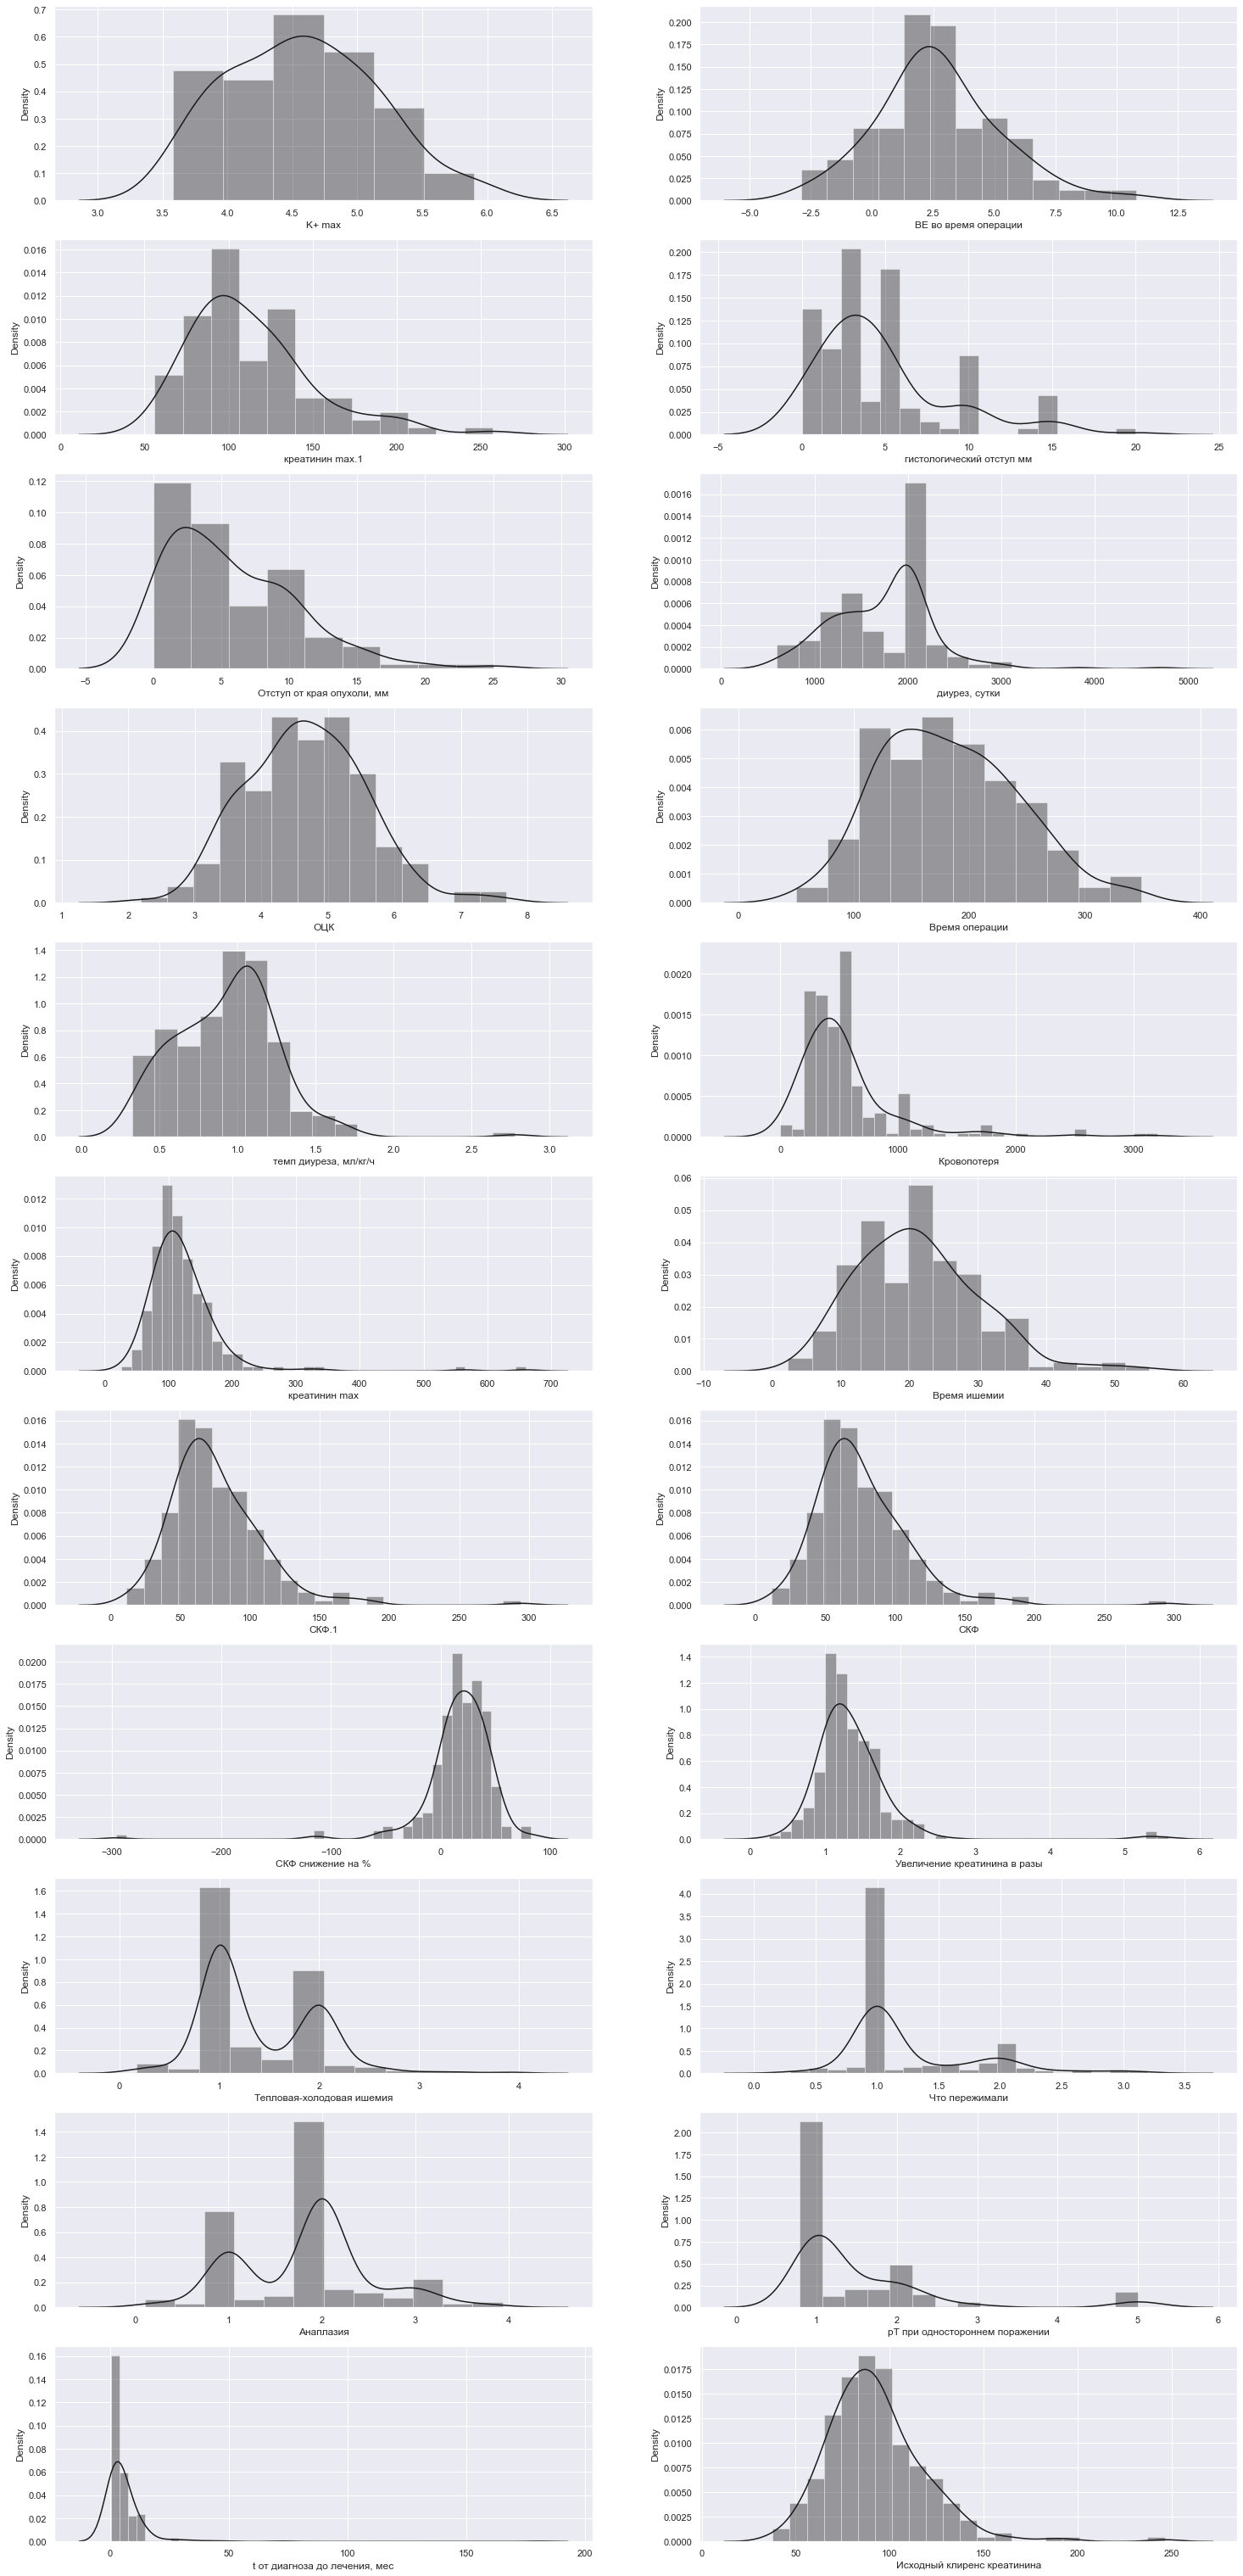

In [30]:
fig, axes = plt.subplots(11, 2, figsize=(25,55))

for i,col in enumerate(df_numcol_nan):
    sns.distplot(df[col], kde=True, ax=axes.flat[i], color='k')

In [31]:
# for col in df_numcol_nan:
#     median = df[col].median()
#     df[col] = df[col].fillna(median)
    
# for col in df_numcol_nan:
#     median = test[col].median()
#     test[col] = test[col].fillna(median)

In [32]:
for col in df_numcol_nan:
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)
    
for col in df_numcol_nan:
    mean = test[col].mean()
    test[col] = test[col].fillna(mean)

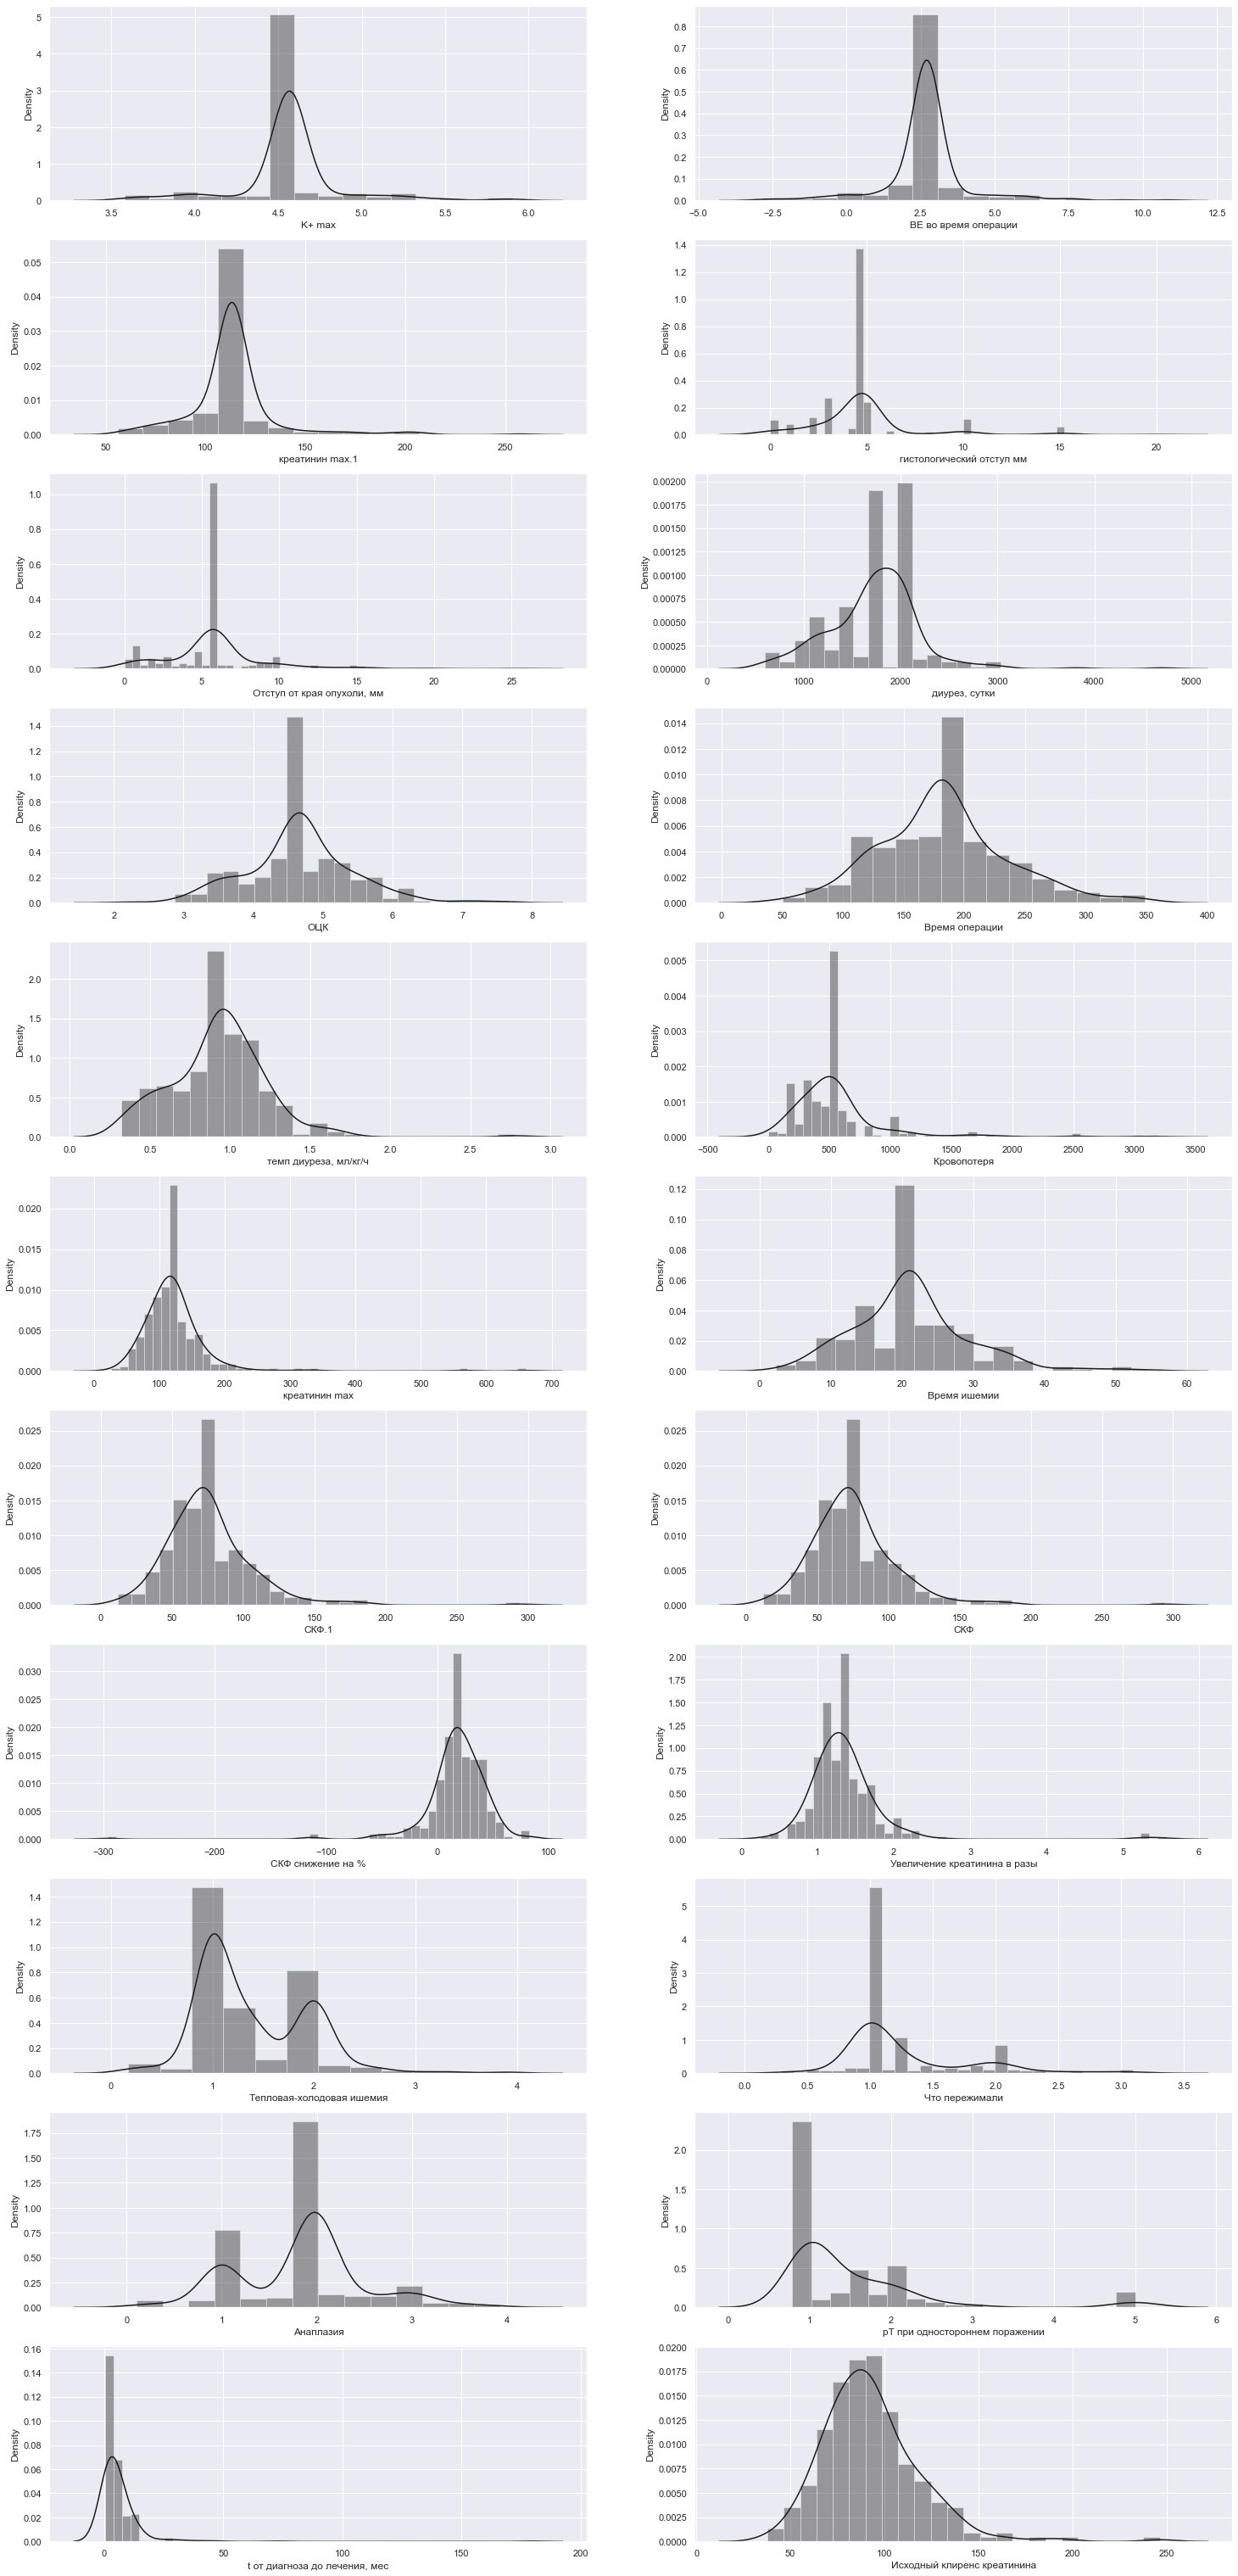

In [33]:
fig, axes = plt.subplots(11, 2, figsize=(25,55))

for i,col in enumerate(df_numcol_nan):
    sns.distplot(df[col], kde=True, ax=axes.flat[i], color='k')

In [34]:
df[df==np.inf]=1

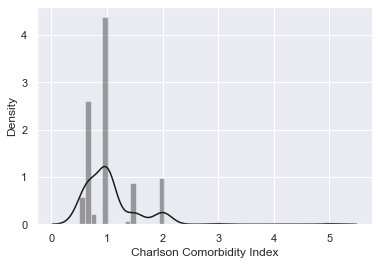

In [35]:
sns.distplot(df['Charlson Comorbidity Index'], kde=True, color='k');

In [36]:
df['Charlson Comorbidity Index'].value_counts()

1.000000    116
0.666667     69
2.000000     26
1.500000     23
0.500000     15
0.750000      6
1.333333      2
5.000000      1
3.000000      1
Name: Charlson Comorbidity Index, dtype: int64

#### Сбалансированные у нас классы?

0    167
1     73
2     19
Name: Текущий прогноз, dtype: int64

Процент живых пациентов 64.479 %
Процент умерших пациентов 28.185 %
Процент пациентов c рецидивом 7.336 %


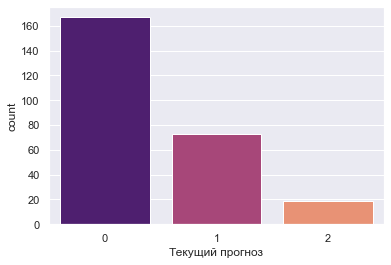

In [37]:
display(df['Текущий прогноз'].value_counts())
count_0 = len(df[df['Текущий прогноз'] == 0])
count_1 = len(df[df['Текущий прогноз'] == 1])
count_2 = len(df[df['Текущий прогноз'] == 2])
print(
    f'Процент живых пациентов {round((count_0/(count_0 + count_1 + count_2))*100, 3)} %')
print(
    f'Процент умерших пациентов {round((count_1/(count_0 + count_1 + count_2))*100, 3)} %')
print(
    f'Процент пациентов c рецидивом {round((count_2/(count_0 + count_1 + count_2))*100, 3)} %')
# print(
#     f'Соотношение примеров {round((count_def/count_no_def)*100, 2)} %')
sns.countplot(df['Текущий прогноз'], palette='magma');

***Вывод:*** наши классы не сбалансированы

In [38]:
df1 = df.copy()

In [39]:
# удалим предполагаемые лишние признаки
df1.drop(['Пол', 'Вес, кг', 'Возраст', 'Рост, см', 'рост2, м2'], 1, inplace=True)
df_bcol.remove('Пол')

df_numcol = list(set(df_numcol) - set(['Вес, кг', 'Возраст', 'Рост, см', 'рост2, м2']))

In [40]:
# добавим новые переменные, объединив старые
df1['RENAL1'] = df1['Renal rim'] + df1['Sinus'] + df1['ЧЛС']\
                + df1['Exophitic'] + df1['RENAL риск (4-6 vs 7-9 vs >=10)']\
                + df1['Экзофит >50% - <50% - эндофит'] + df1['синус/члс >7, 4-7, <=4 мм']
df_bcol = list(set(df_bcol) - set(['Renal rim', 'Sinus', 'ЧЛС']))
df_catcol = list(set(df_catcol) - set(['Exophitic', 'RENAL риск (4-6 vs 7-9 vs >=10)',\
                                       'Экзофит >50% - <50% - эндофит', 'синус/члс >7, 4-7, <=4 мм']))
df1.drop(['Renal rim', 'Sinus', 'ЧЛС', 'Exophitic', 'RENAL риск (4-6 vs 7-9 vs >=10)',\
          'Экзофит >50% - <50% - эндофит', 'синус/члс >7, 4-7, <=4 мм'], 1, inplace=True)

df1['Осложнения_хир'] = df1['Осложнения интраоперационные'] + df1['хирургические осложнения ранние']
df_bcol = list(set(df_bcol) - set(['Осложнения интраоперационные', 'хирургические осложнения ранние']))
df1.drop(['Осложнения интраоперационные', 'хирургические осложнения ранние'], 1, inplace=True)

df1['Прочие осложнения'] = df1['осложнения поздние'] + df1['Осложнения п\\о ранние']\
                    + df1['Осложнения лечения'] + df1['Осложнения интраоперационные.1']\
                    + df1['нехирургические ранние осложнения кроме ПН']
df_bcol = list(set(df_bcol) - set(['осложнения поздние', 'Осложнения п\\о ранние', 'Осложнения лечения']))
df_catcol = list(set(df_catcol) - set(['нехирургические ранние осложнения кроме ПН', 'Осложнения интраоперационные.1']))
df1.drop(['осложнения поздние', 'Осложнения п\\о ранние', 'Осложнения лечения',\
          'нехирургические ранние осложнения кроме ПН', 'Осложнения интраоперационные.1'], 1, inplace=True)
                 
df1['РЕЦИДИВ'] = df1['Рецидив'] + df1['вид рецидива'] + df1['мтс'] + df1['местный']\
                 + df1['системное лечение'] +df1['Лечение рецидива'] + df1['эффект лечения рецидива']
df_bcol = list(set(df_bcol) - set(['Рецидив', 'вид рецидива', 'мтс', 'местный', 'системное лечение']))
df_catcol = list(set(df_catcol) - set(['Лечение рецидива', 'эффект лечения рецидива']))
df1.drop(['Рецидив', 'вид рецидива', 'мтс', 'местный', 'системное лечение',\
         'Лечение рецидива', 'эффект лечения рецидива'], 1, inplace=True)    

df1['Доступ_1_резекции'] = df1['Доступ первой резекции'] + df1['Доступ первой резекции.1']
df_bcol = list(set(df_bcol) - set(['Доступ первой резекции', 'Доступ первой резекции.1']))
df1.drop(['Доступ первой резекции', 'Доступ первой резекции.1'], 1, inplace=True)       

df1['РАЗМЕР'] = df1['Размер'] + df1['Размер.1']
df_catcol = list(set(df_catcol) - set(['Размер', 'Размер.1']))
df1.drop(['Размер', 'Размер.1'], 1, inplace=True)  

df1['Болезни'] = df1['Болезни, влияющие на ф-цию почек'] + df1['Comorbidity Component']
df_bcol.remove('Болезни, влияющие на ф-цию почек')
df_catcol.remove('Comorbidity Component')
df1.drop(['Болезни, влияющие на ф-цию почек', 'Comorbidity Component'], 1, inplace=True)                  
                 
df1['ХПН_Стадии'] = df1['ХПН'] + df1['стадия ХПН'] + df1['Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30']
df_bcol.remove('ХПН')
df_catcol = list(set(df_catcol) - set(['стадия ХПН', 'Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30']))
df1.drop(['ХПН', 'стадия ХПН', 'Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30'], 1, inplace=True)       
                 
df1['ГИСТОЛОГИЯ'] = df1['Срочная гистология'] + df1['Гистология']
df_bcol.remove('Срочная гистология')
df_numcol.remove('Гистология')
df1.drop(['Срочная гистология', 'Гистология'], 1, inplace=True) 

df1['СКФ_СКФ'] = np.sqrt(df1['СКФ'] * df1['СКФ.1'])
df_numcol = list(set(df_numcol) - set(['СКФ', 'СКФ.1']))
df1.drop(['СКФ', 'СКФ.1'], 1, inplace=True)                  

In [41]:
df_catcol.append('RENAL1')
df_catcol.append('Осложнения_хир')
df_catcol.append('Прочие осложнения')
df_catcol.append('РЕЦИДИВ')
df_bcol.append('Доступ_1_резекции')
df_catcol.append('РАЗМЕР')
df_catcol.append('Болезни')
df_catcol.append('ХПН_Стадии')
df_catcol.append('ГИСТОЛОГИЯ')
df_numcol.append('СКФ_СКФ')

In [42]:
test.drop(['Пол', 'Вес, кг', 'Возраст', 'Рост, см', 'рост2, м2'], 1, inplace=True)

test['RENAL1'] = test['Renal rim'] + test['Sinus'] + test['ЧЛС']\
                + test['Exophitic'] + test['RENAL риск (4-6 vs 7-9 vs >=10)']\
                + test['Экзофит >50% - <50% - эндофит'] + test['синус/члс >7, 4-7, <=4 мм']
test.drop(['Renal rim', 'Sinus', 'ЧЛС', 'Exophitic', 'RENAL риск (4-6 vs 7-9 vs >=10)',\
          'Экзофит >50% - <50% - эндофит', 'синус/члс >7, 4-7, <=4 мм'], 1, inplace=True)

test['Осложнения_хир'] = test['Осложнения интраоперационные'] + test['хирургические осложнения ранние']
test.drop(['Осложнения интраоперационные', 'хирургические осложнения ранние'], 1, inplace=True)

test['Прочие осложнения'] = test['осложнения поздние'] + test['Осложнения п\\о ранние']\
                    + test['Осложнения лечения'] + test['Осложнения интраоперационные.1']\
                    + test['нехирургические ранние осложнения кроме ПН']
test.drop(['осложнения поздние', 'Осложнения п\\о ранние', 'Осложнения лечения',\
          'нехирургические ранние осложнения кроме ПН', 'Осложнения интраоперационные.1'], 1, inplace=True)
                 
test['РЕЦИДИВ'] = test['Рецидив'] + test['вид рецидива'] + test['мтс'] + test['местный']\
                 + test['системное лечение'] + test['Лечение рецидива'] + test['эффект лечения рецидива']
test.drop(['Рецидив', 'вид рецидива', 'мтс', 'местный', 'системное лечение',\
         'Лечение рецидива', 'эффект лечения рецидива'], 1, inplace=True)    

test['Доступ_1_резекции'] = test['Доступ первой резекции'] + test['Доступ первой резекции.1']
test.drop(['Доступ первой резекции', 'Доступ первой резекции.1'], 1, inplace=True)       

test['РАЗМЕР'] = test['Размер'] + test['Размер.1']
test.drop(['Размер', 'Размер.1'], 1, inplace=True)  

test['Болезни'] = test['Болезни, влияющие на ф-цию почек'] + test['Comorbidity Component']
test.drop(['Болезни, влияющие на ф-цию почек', 'Comorbidity Component'], 1, inplace=True)                  
                 
test['ХПН_Стадии'] = test['ХПН'] + test['стадия ХПН'] + test['Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30']
test.drop(['ХПН', 'стадия ХПН', 'Стадии ХБП до резекции 60-90, 45-59, 30-45, 14-30'], 1, inplace=True)       
                 
test['ГИСТОЛОГИЯ'] = test['Срочная гистология'] + test['Гистология']
test.drop(['Срочная гистология', 'Гистология'], 1, inplace=True) 

test['СКФ_СКФ'] = np.sqrt(test['СКФ'] * test['СКФ.1'])
test.drop(['СКФ', 'СКФ.1'], 1, inplace=True)    

### Корреляционный анализ

#### Бинарные переменные

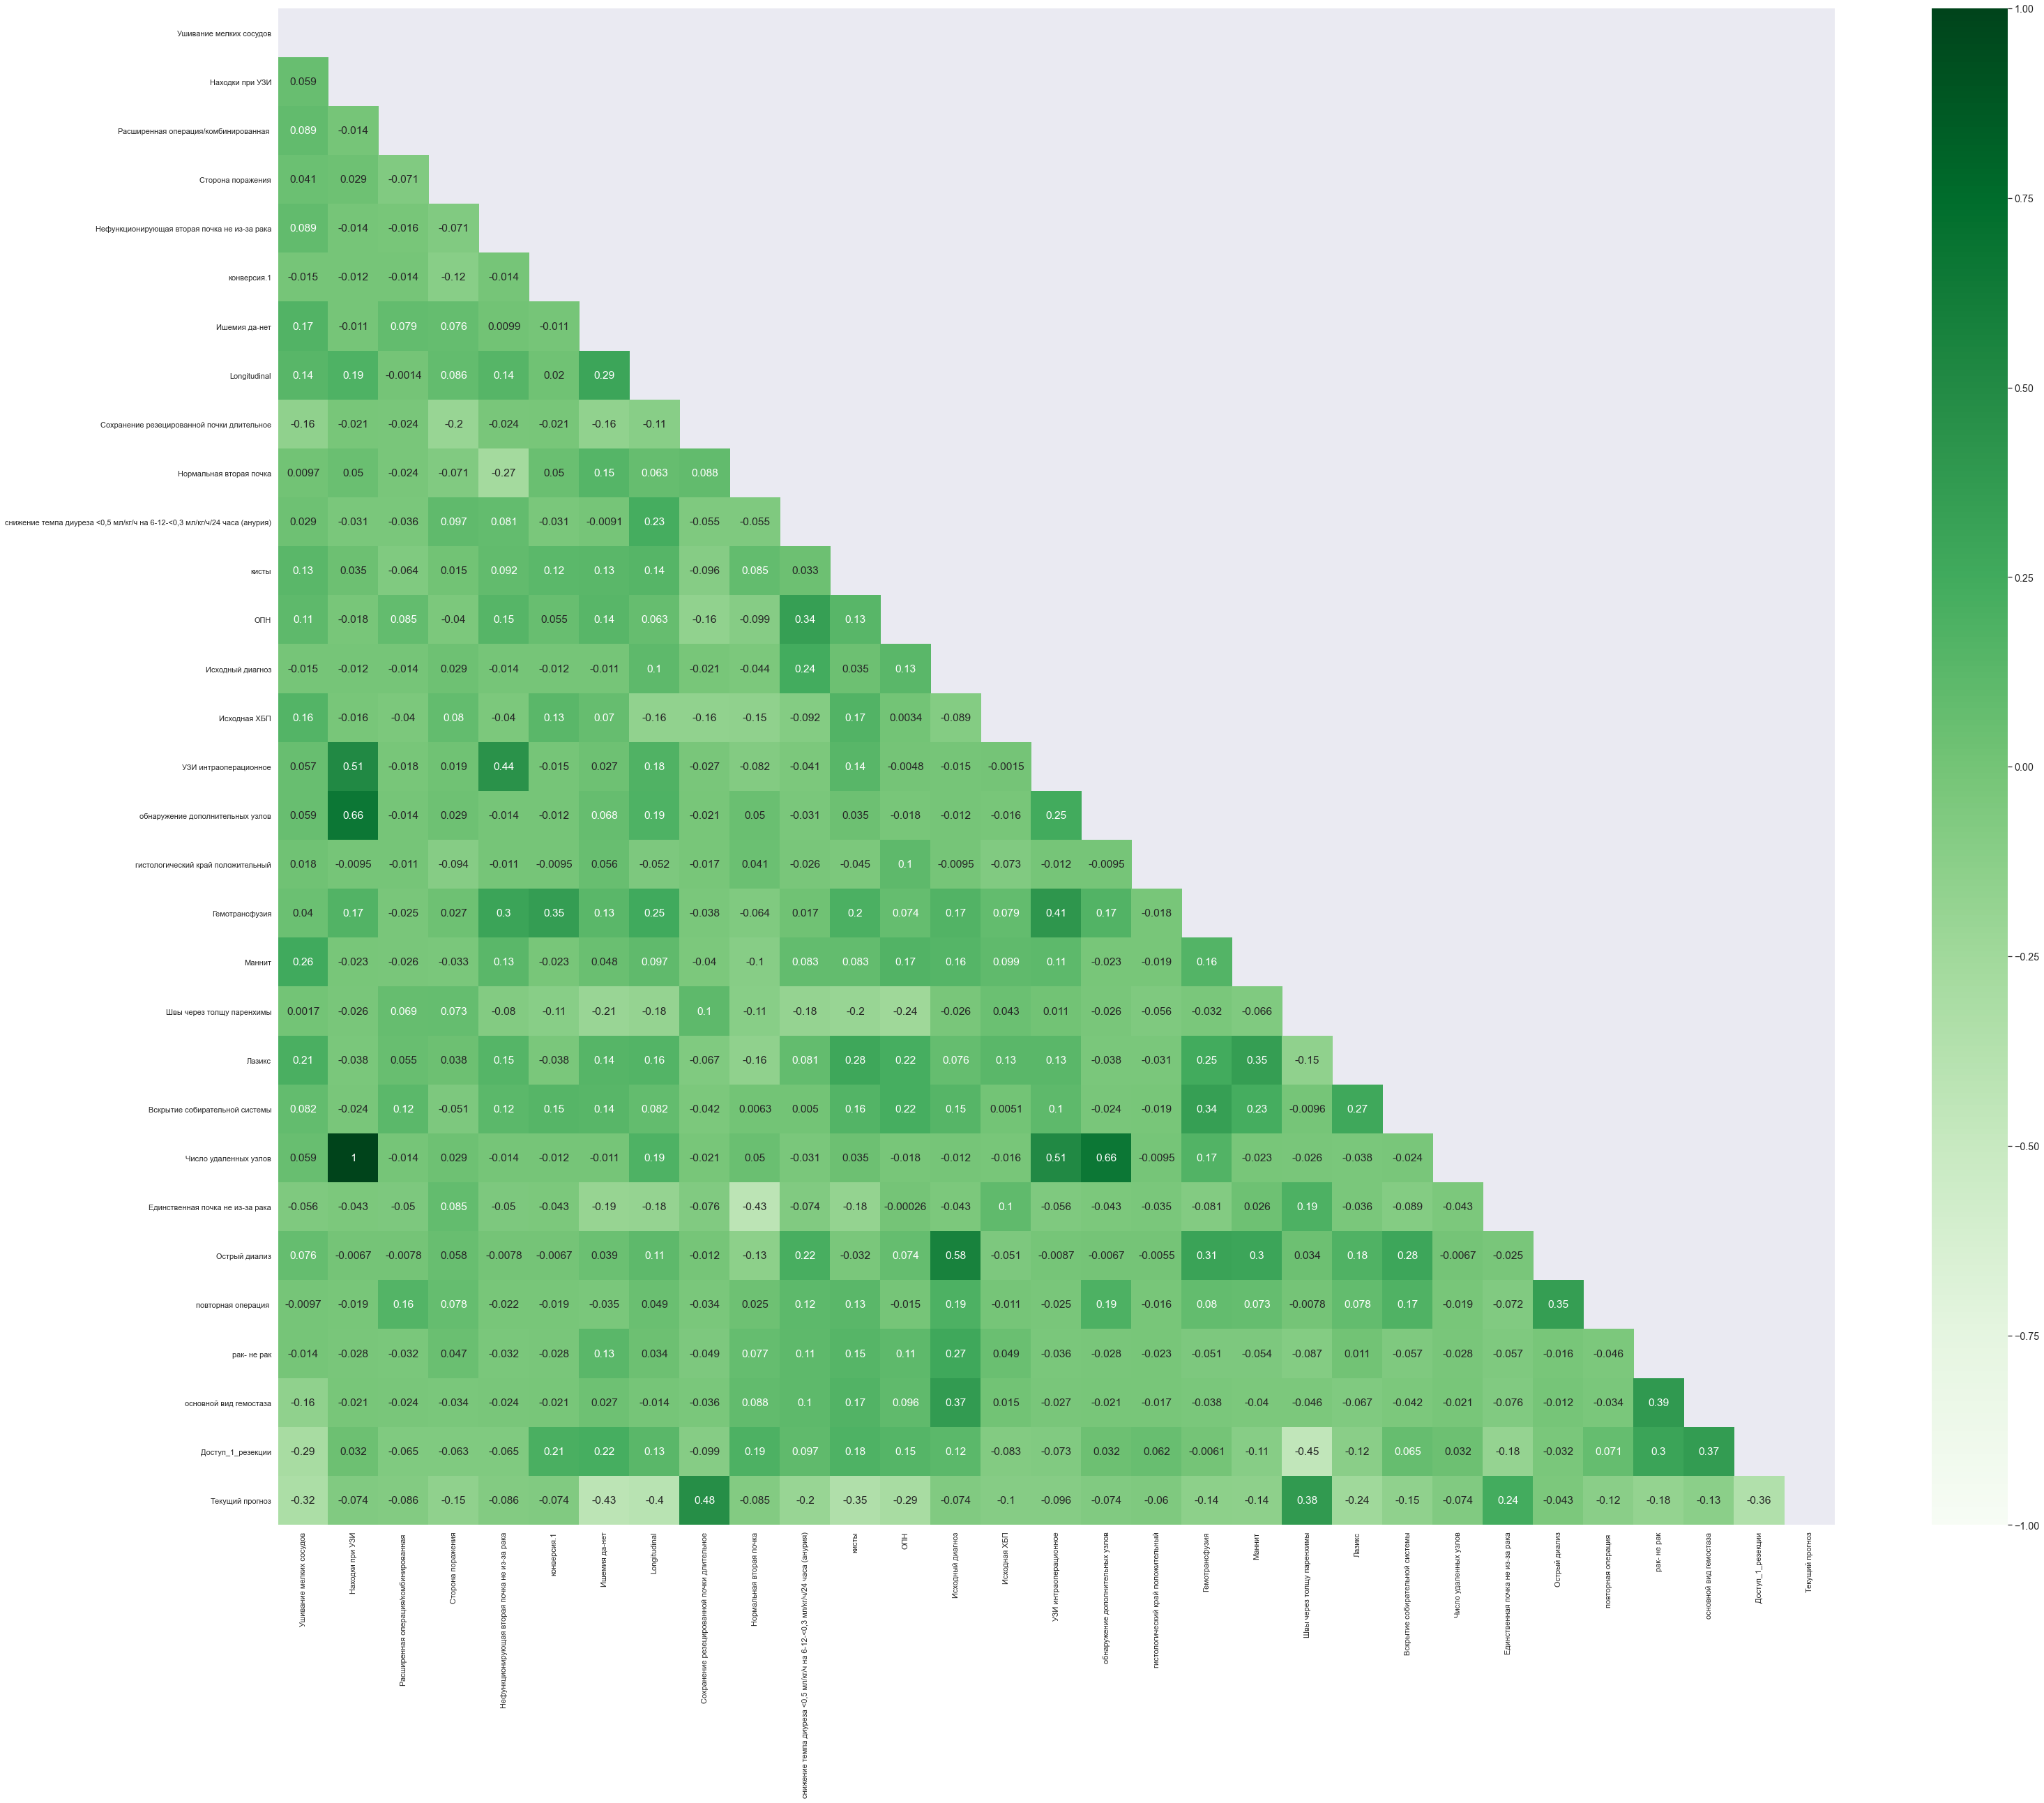

In [43]:
corrmat = df1[df_bcol + ['Текущий прогноз']].corr()

fig, ax = plt.subplots(figsize=(50,40))

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.3)
sns.heatmap(corrmat, mask=mask, vmax=1, vmin=-1, annot=True, center=0, cmap='Greens');

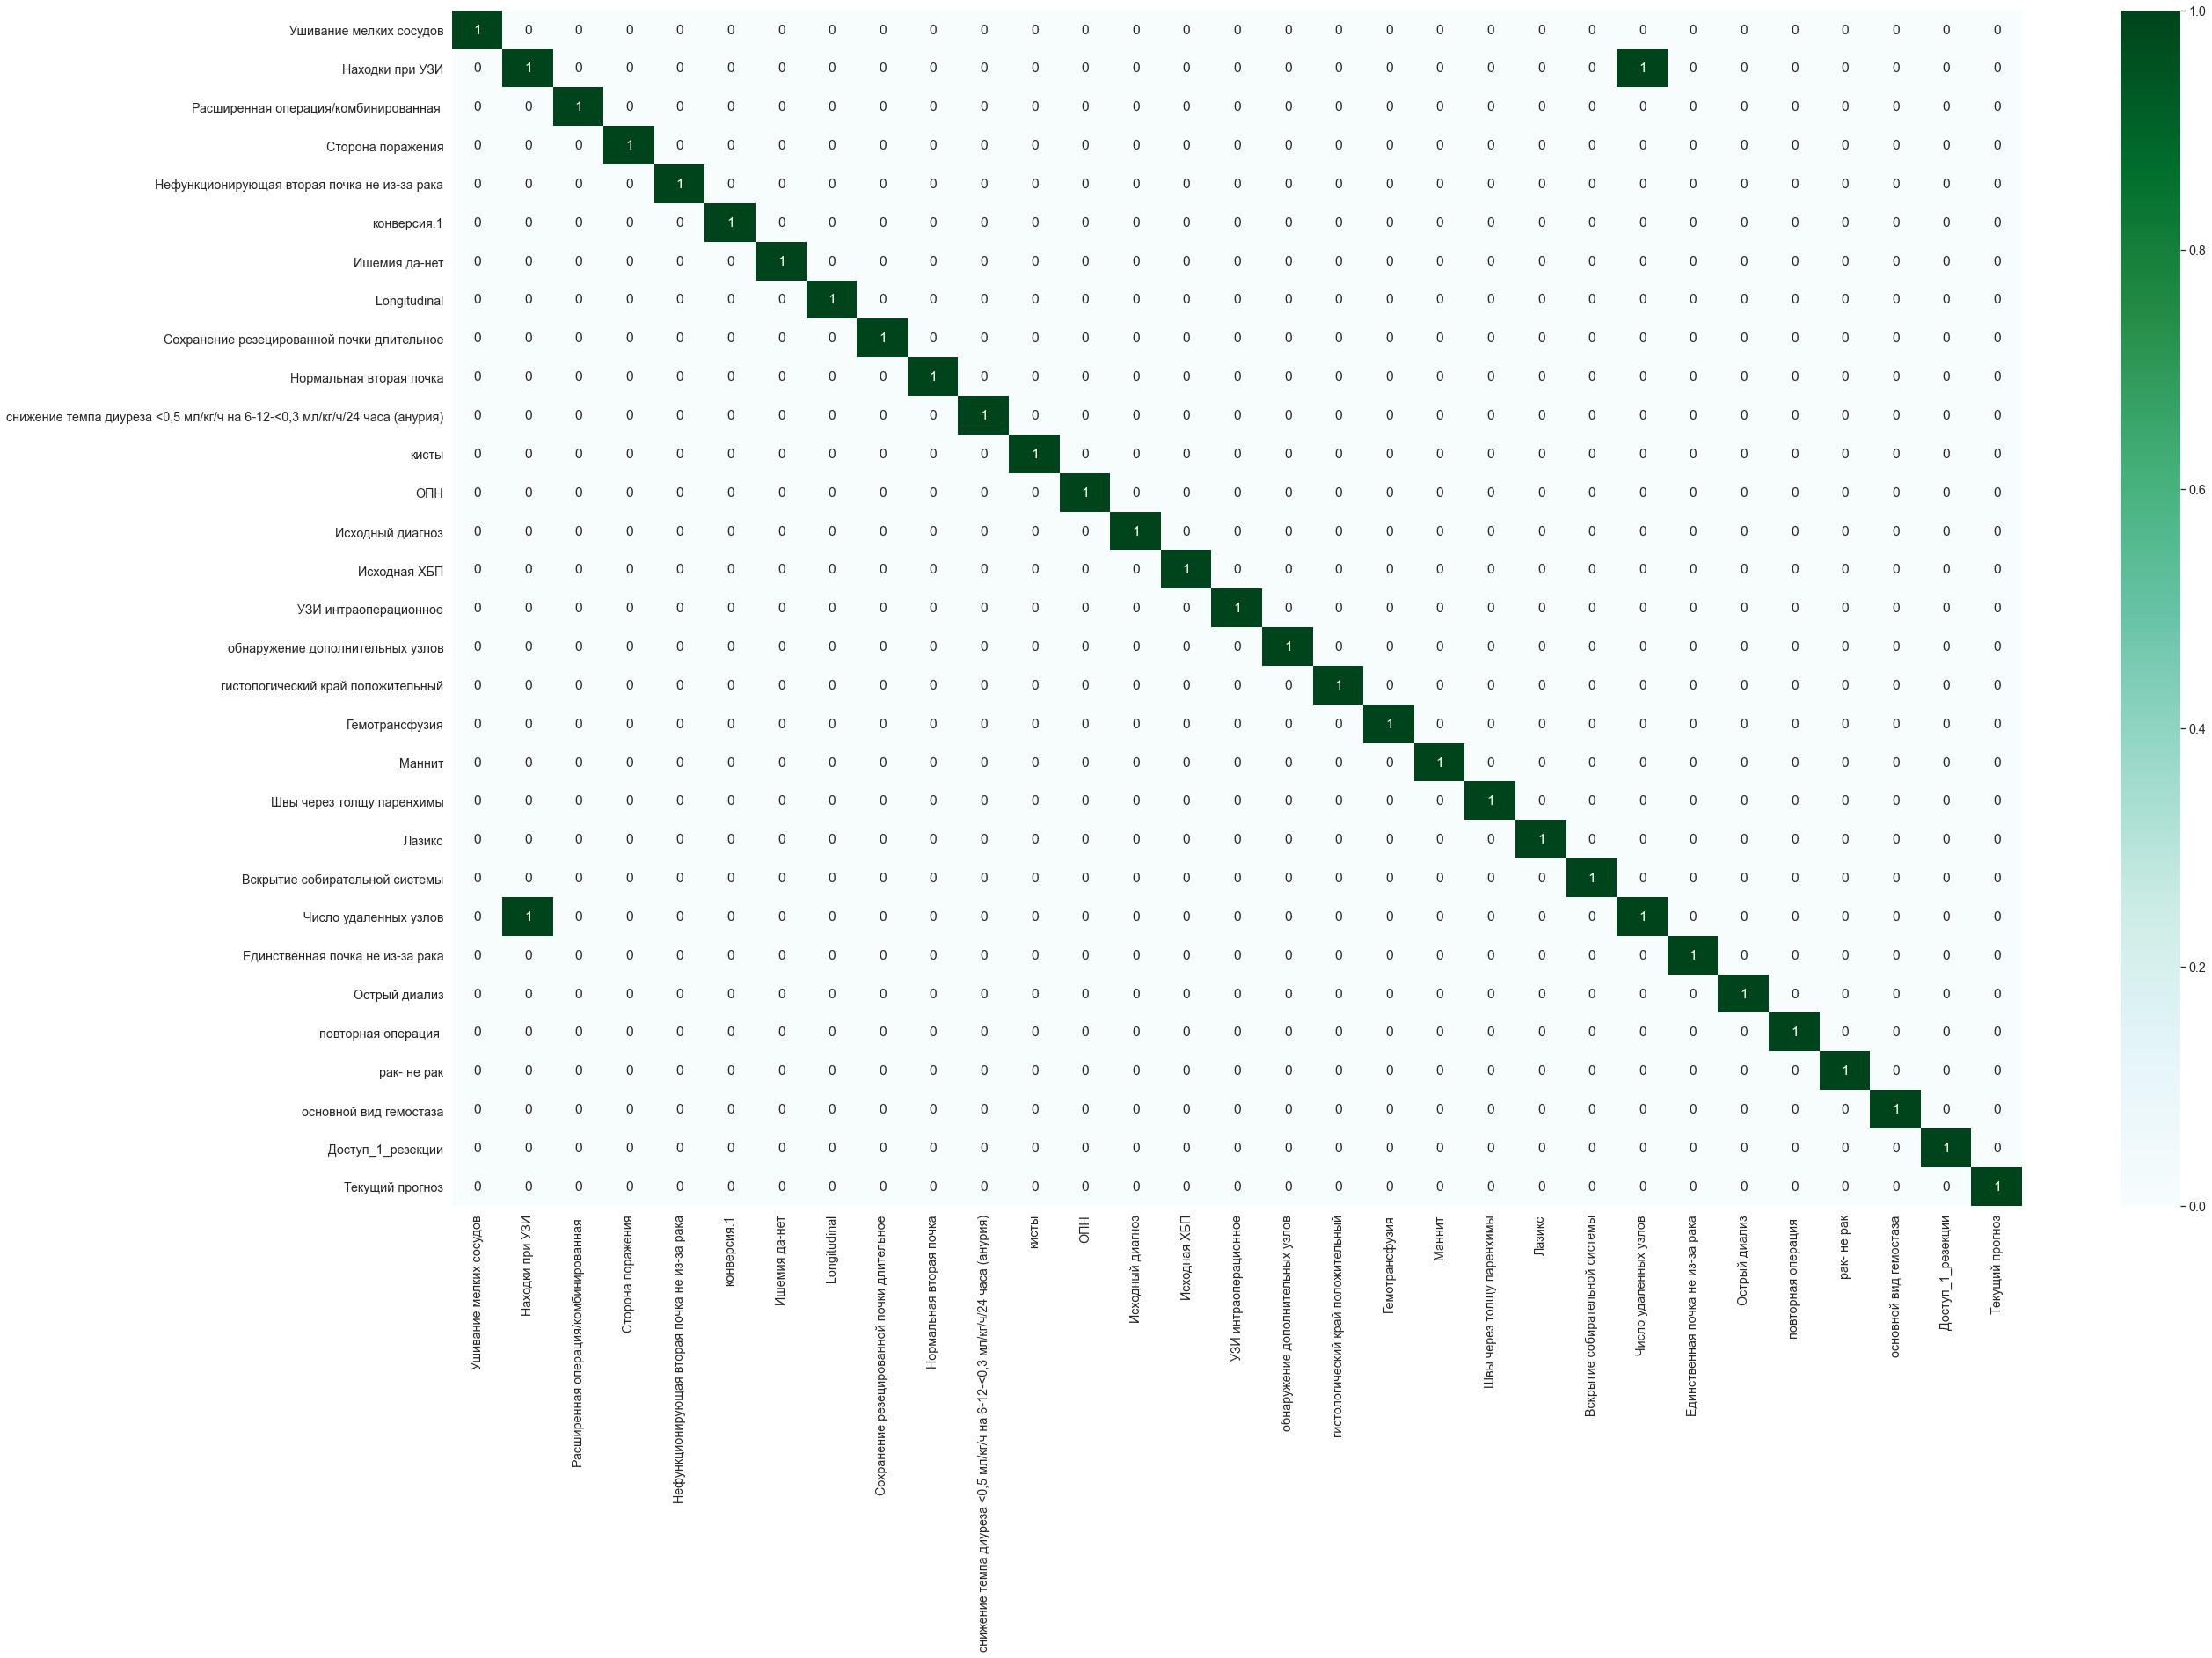

In [44]:
fig, ax = plt.subplots(figsize=(40, 25))
corrmat1 = abs(df1[df_bcol + ['Текущий прогноз']].corr())

sns.heatmap(corrmat1>0.7, vmin=0, vmax=1, annot=True, cmap='BuGn');

In [45]:
# corrmat

**Вывод:** 
1. Признаки `'Доступ первой резекции'` и `'Доступ первой резекции.1'`, а также `'Число удаленных узлов'` и `'Находки при УЗИ'` полностью скоррелированы друг с другом, поэтому удалим следующие признаки: `'Доступ первой резекции.1'`, `'Находки при УЗИ'`;
2. Наиболее сильно с таргетом скоррелированы признаки `'Рецидив'` и `'вид рецидива'`

In [46]:
# df.drop(['Доступ первой резекции.1', 'Находки при УЗИ'], 1, inplace=True)
# test.drop(['Доступ первой резекции.1', 'Находки при УЗИ'], 1, inplace=True)
# df_bcol = list(set(df_bcol) - set(['Доступ первой резекции.1', 'Находки при УЗИ']))
# test_bcol = list(set(df_bcol) - set(['Доступ первой резекции.1', 'Находки при УЗИ']))

In [47]:
df1.drop(['Находки при УЗИ'], 1, inplace=True)
df_bcol.remove('Находки при УЗИ')

#### Категориальные переменные

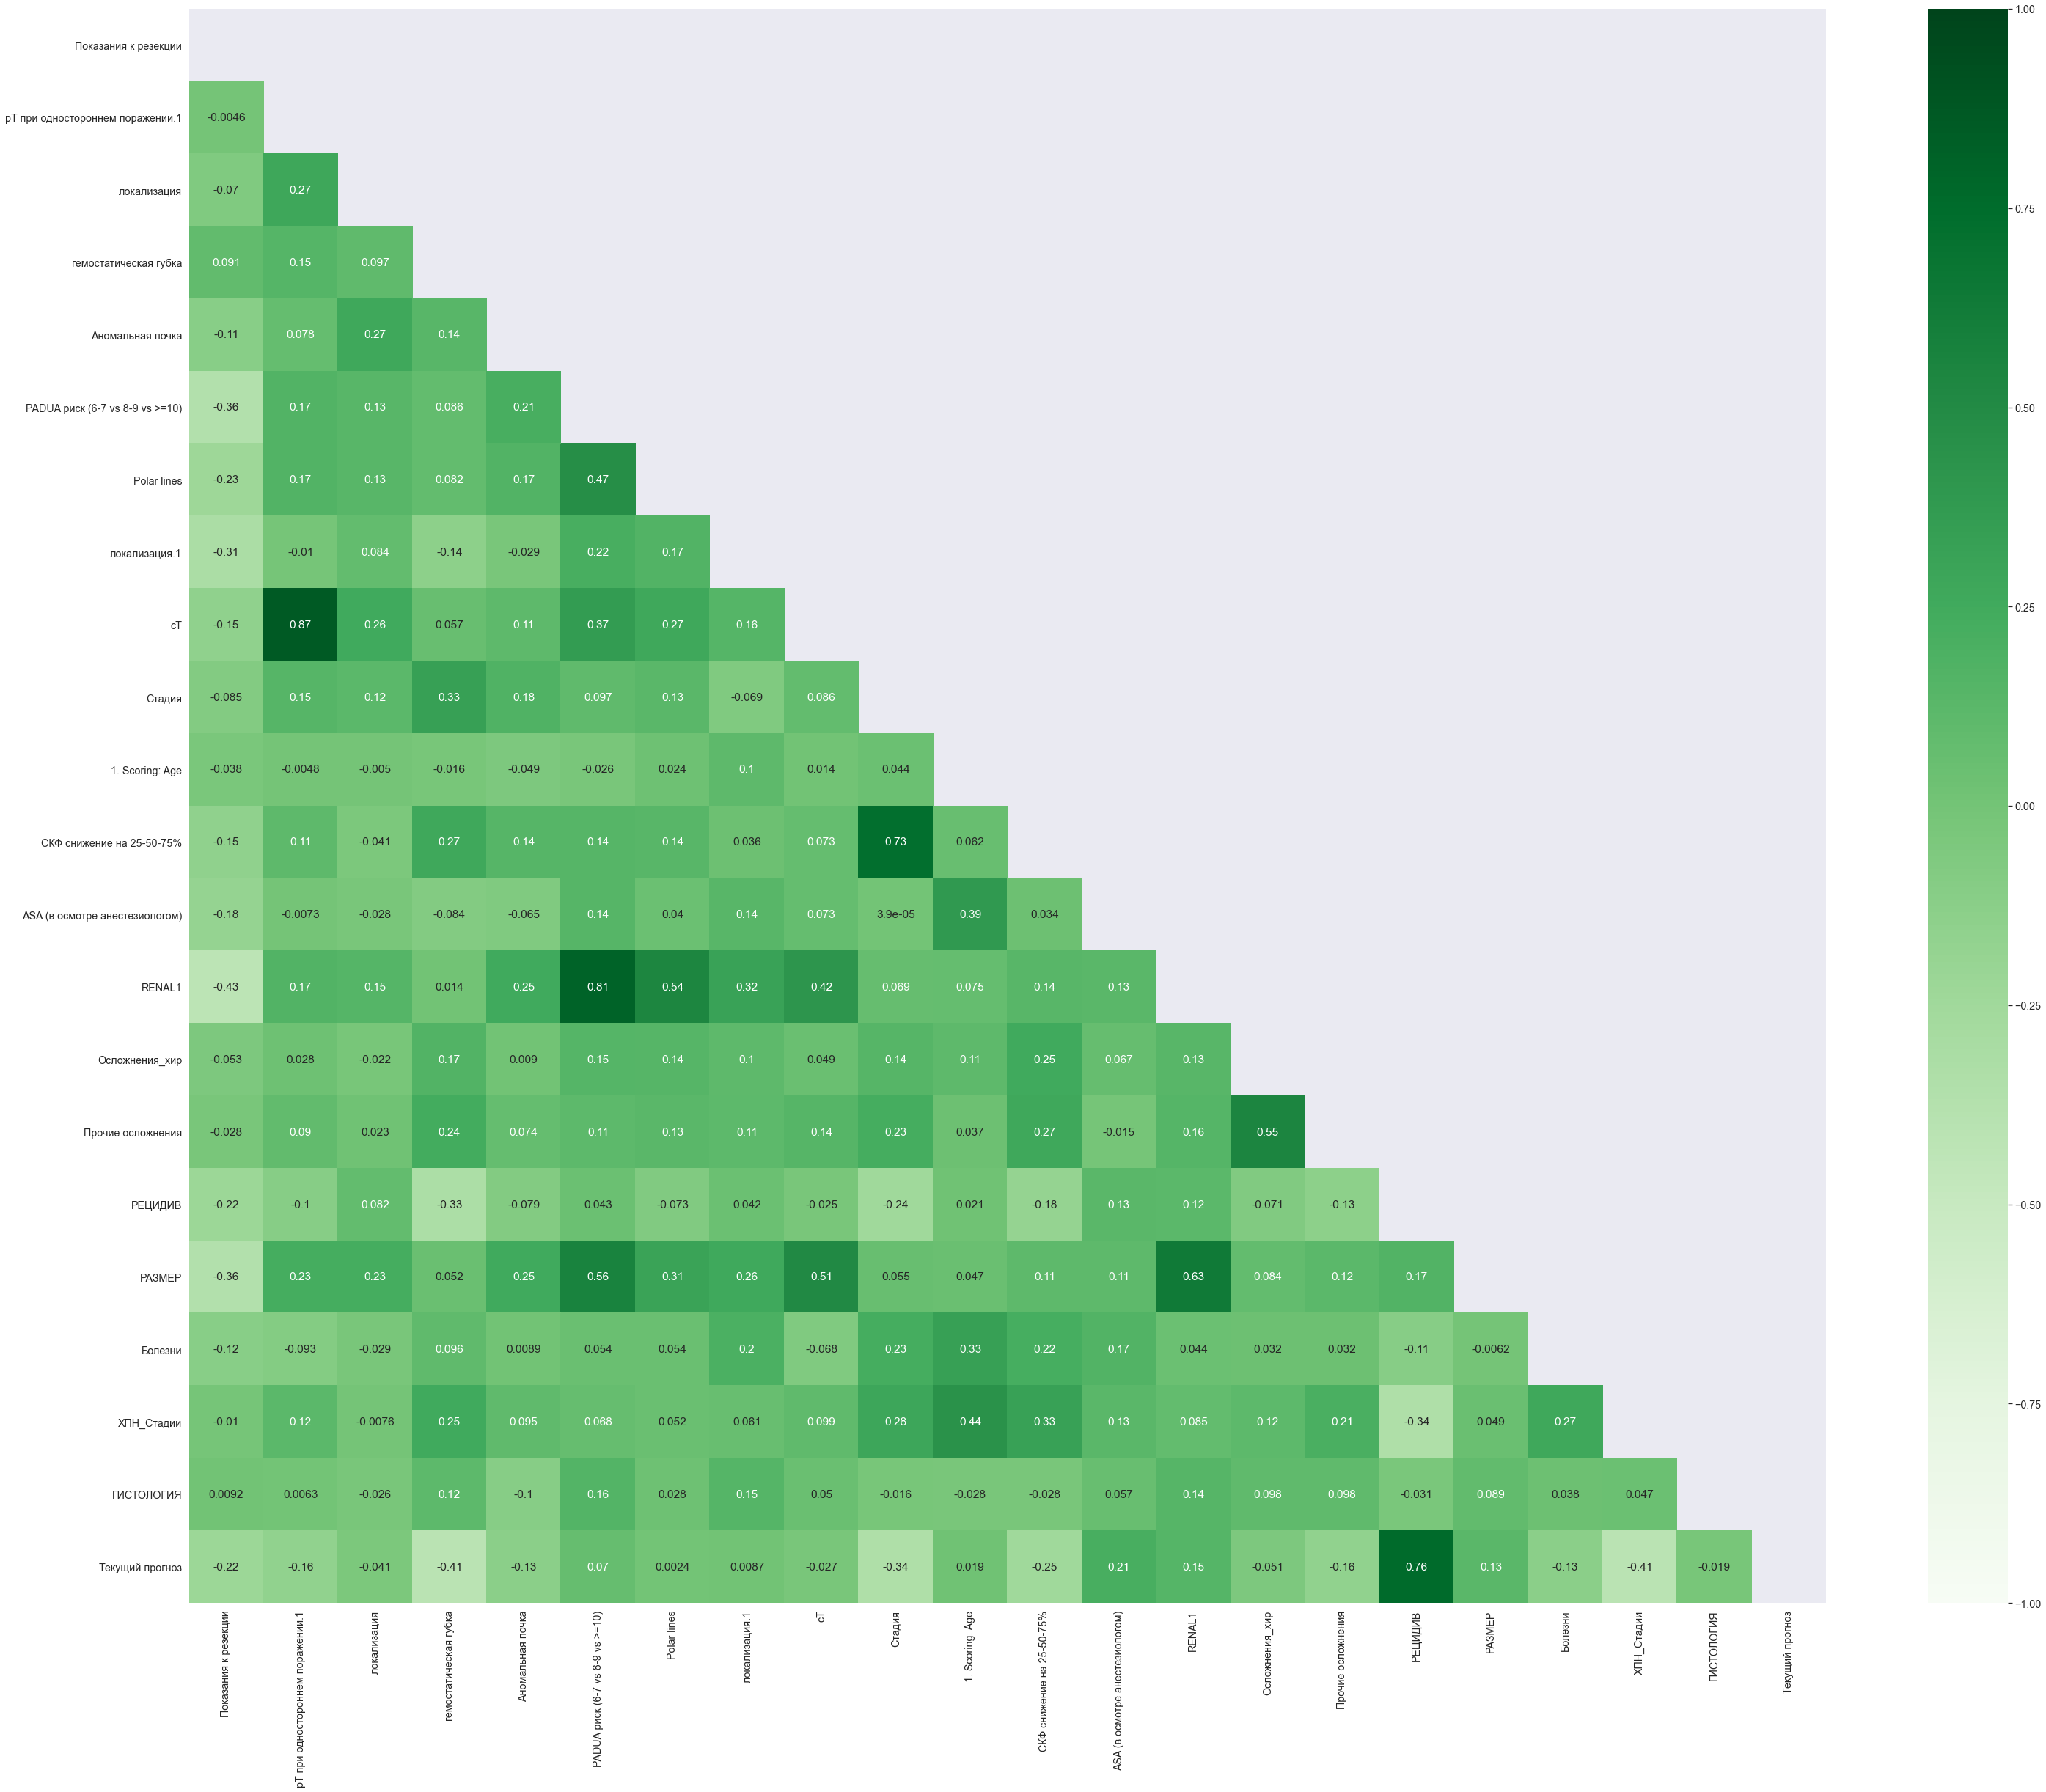

In [48]:
corrmat = df1[df_catcol + ['Текущий прогноз']].corr()

fig, ax = plt.subplots(figsize=(50,40))

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.3)
sns.heatmap(corrmat, mask=mask, vmax=1, vmin=-1, annot=True, center=0, cmap='Greens');

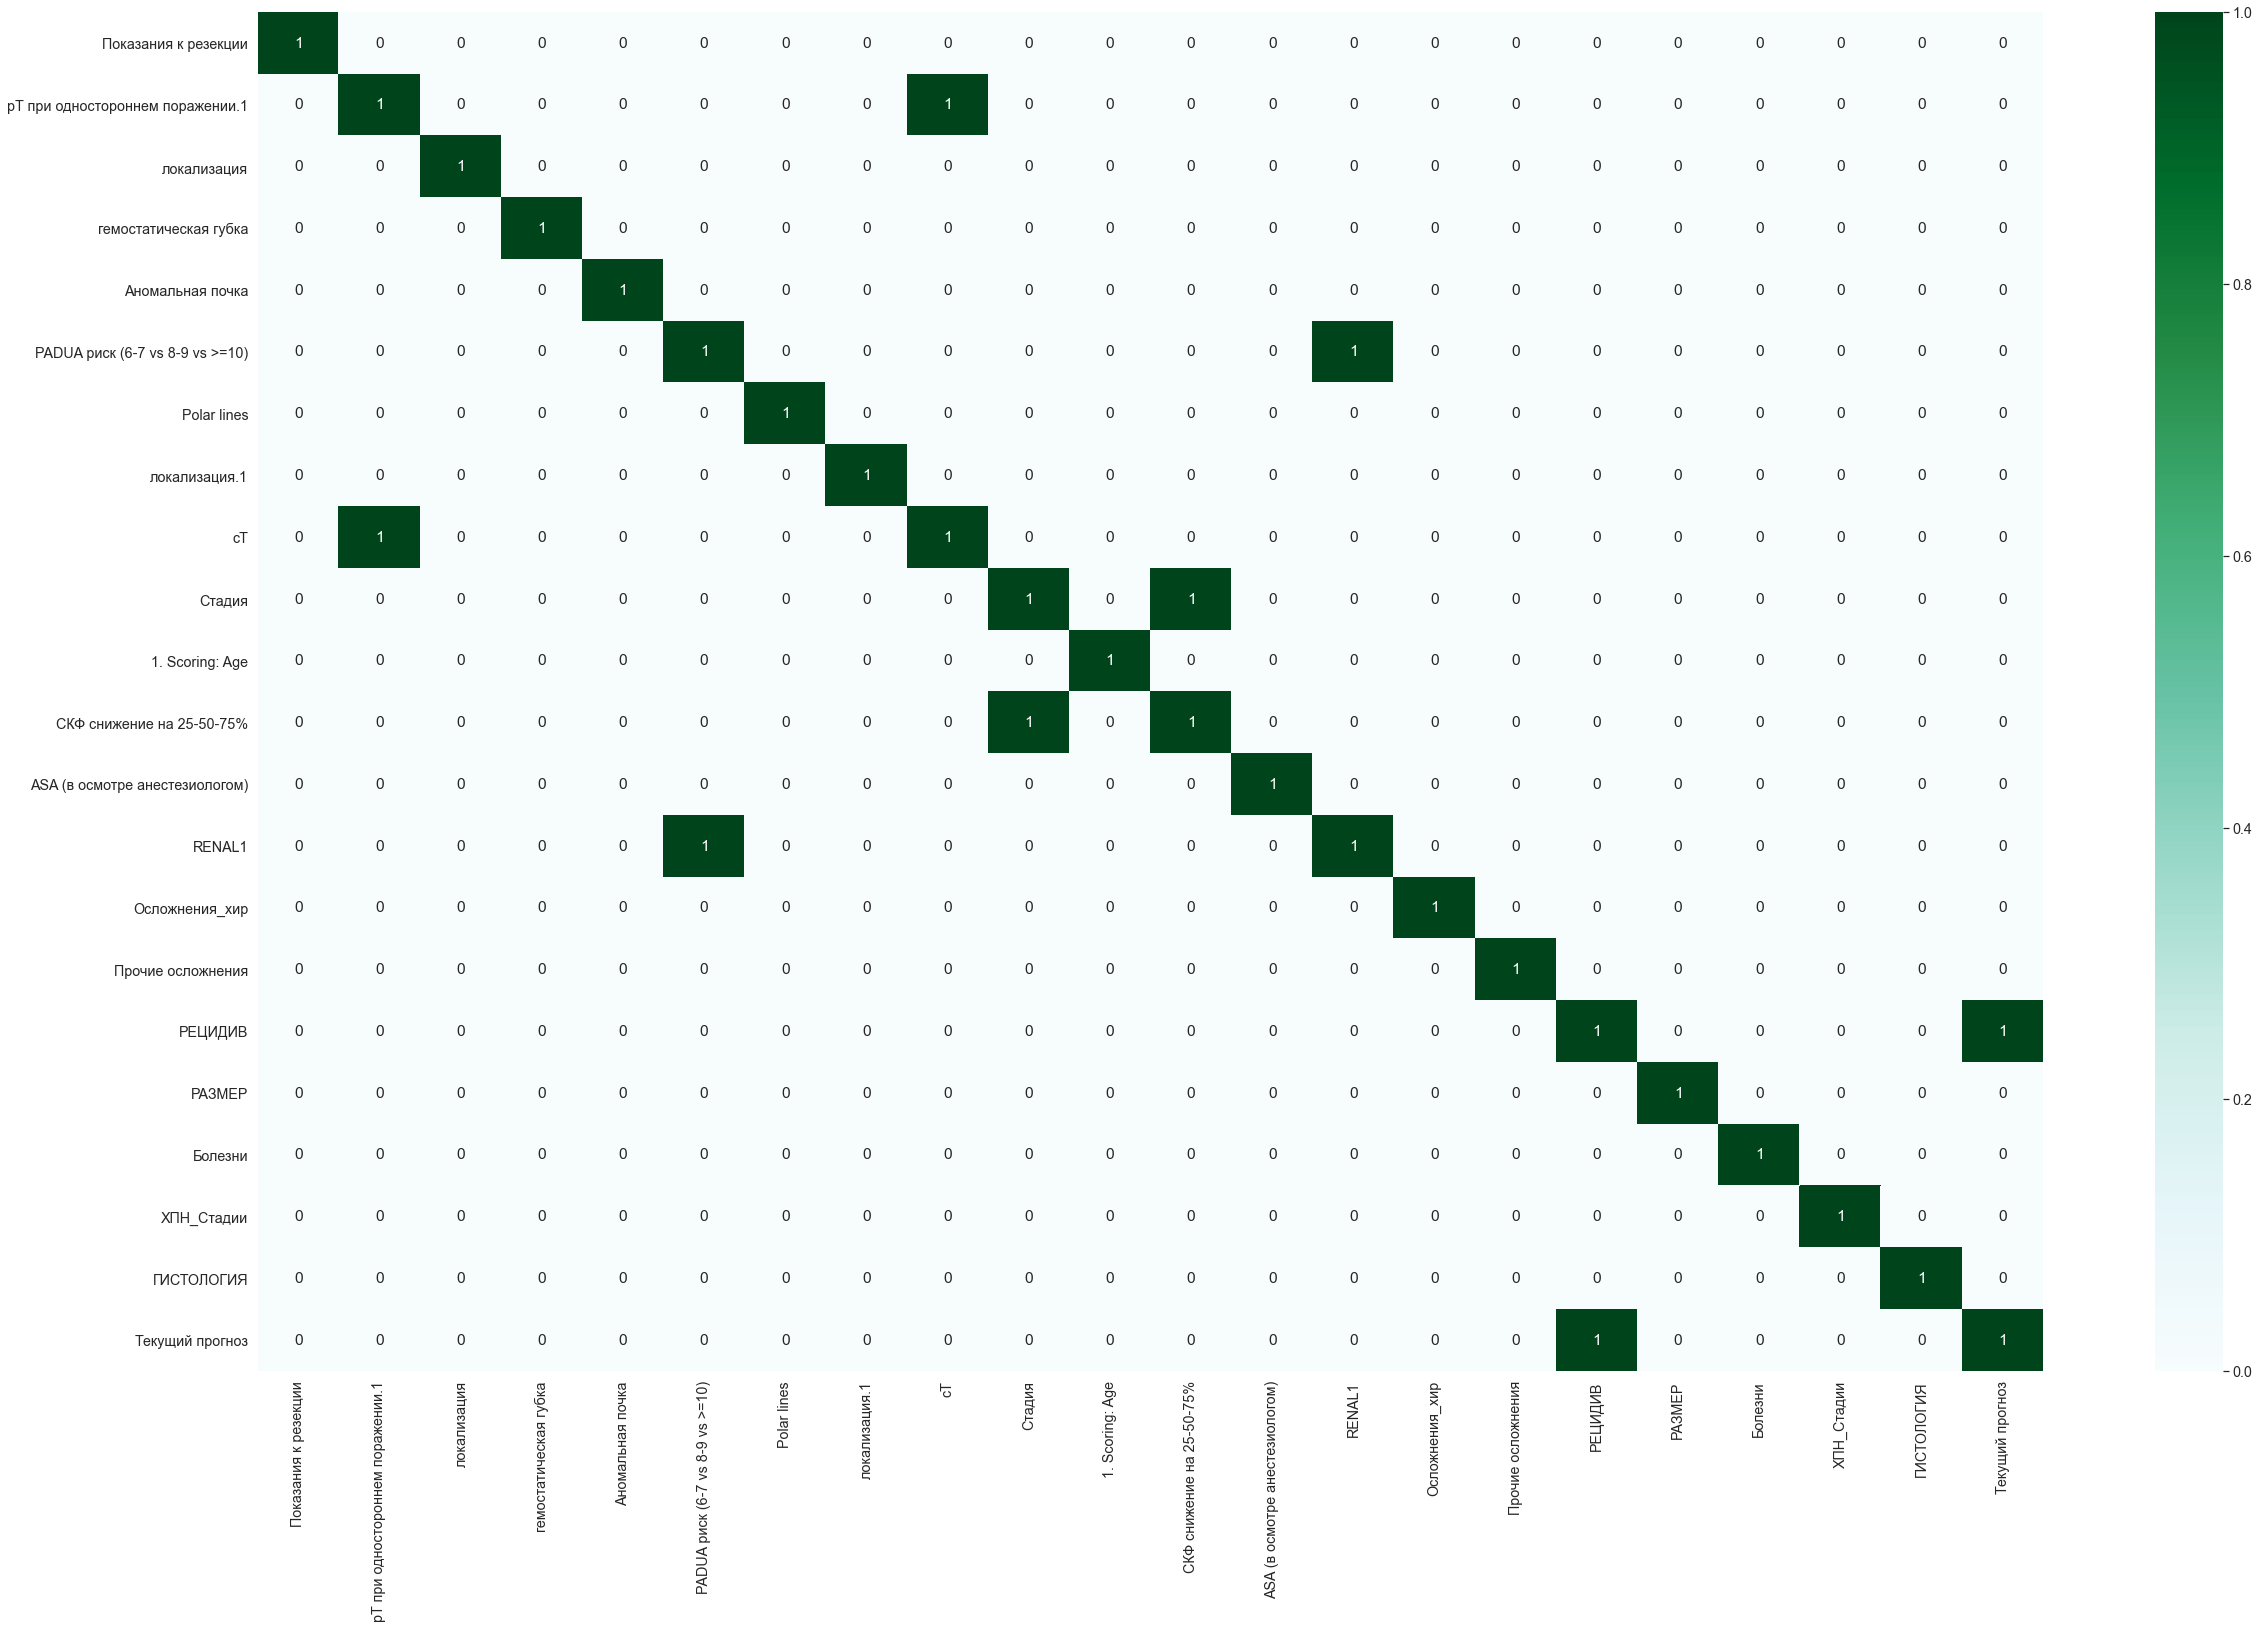

In [49]:
fig, ax = plt.subplots(figsize=(40, 25))
corrmat1 = abs(df1[df_catcol + ['Текущий прогноз']].corr())

sns.heatmap(corrmat1>0.7, vmin=0, vmax=1, annot=True, cmap='BuGn');

In [50]:
# corrmat

**Вывод:** 
1. Признаки `'Размер'` и `'Размер.1'`, а также `'Стадия'` и `'СКФ снижение на 25-50-75%'` полностью скоррелированы друг с другом, поэтому удалим следующие признаки: `'Размер.1'`, `'СКФ снижение на 25-50-75%'`;
2. Наиболее сильно с таргетом скоррелированы признаки `'Лечение рецидива'` и `'эффект лечения рецидива'`

In [51]:
# df.drop(['Размер.1', 'СКФ снижение на 25-50-75%'], 1, inplace=True)
# test.drop(['Размер.1', 'СКФ снижение на 25-50-75%'], 1, inplace=True)
# df_catcol = list(set(df_catcol) - set(['Размер.1', 'СКФ снижение на 25-50-75%']))
# test_catcol = list(set(df_catcol) - set(['Размер.1', 'СКФ снижение на 25-50-75%']))

In [52]:
df1.drop(['СКФ снижение на 25-50-75%', 'pT при одностороннем поражении.1', 'PADUA риск (6-7 vs 8-9 vs >=10)'], 1, inplace=True)
df_catcol = list(set(df_catcol) - set(['pT при одностороннем поражении.1', 'СКФ снижение на 25-50-75%', 'PADUA риск (6-7 vs 8-9 vs >=10)']))

#### Числовые переменные

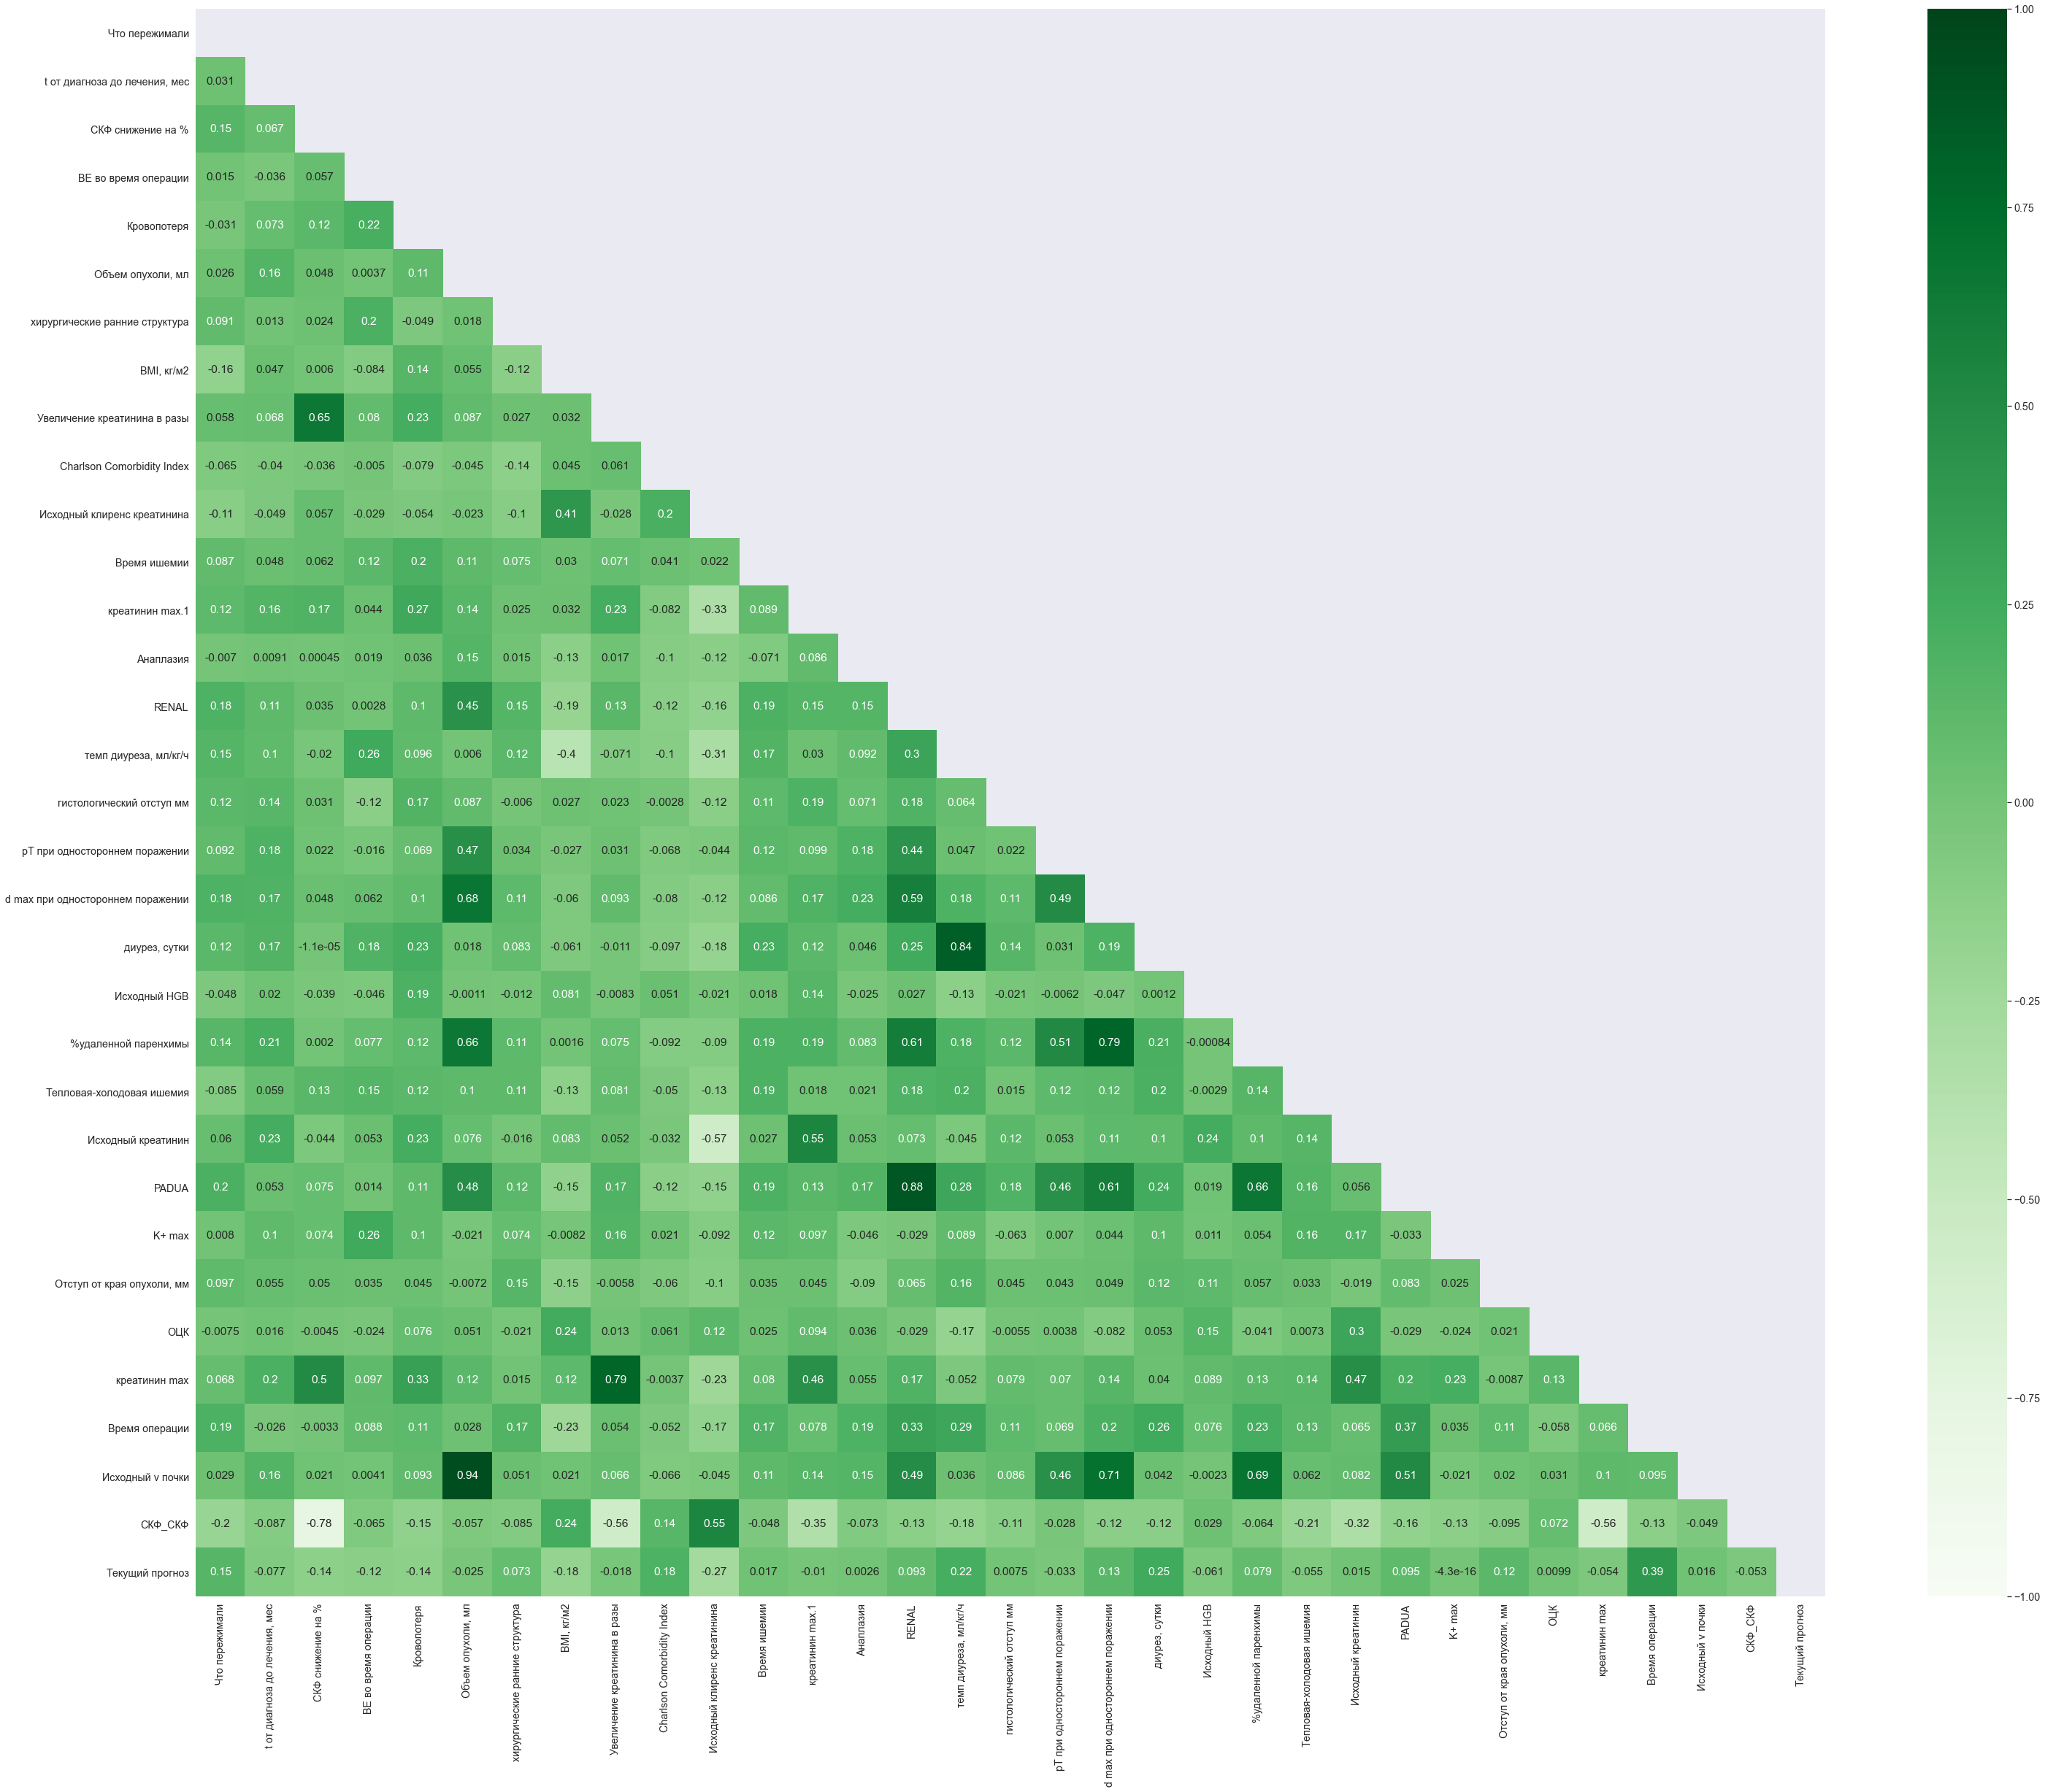

In [53]:
corrmat = df1[df_numcol + ['Текущий прогноз']].corr()

fig, ax = plt.subplots(figsize=(50,40))

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.3)
sns.heatmap(corrmat, mask=mask, vmax=1, vmin=-1, annot=True, center=0, cmap='Greens');

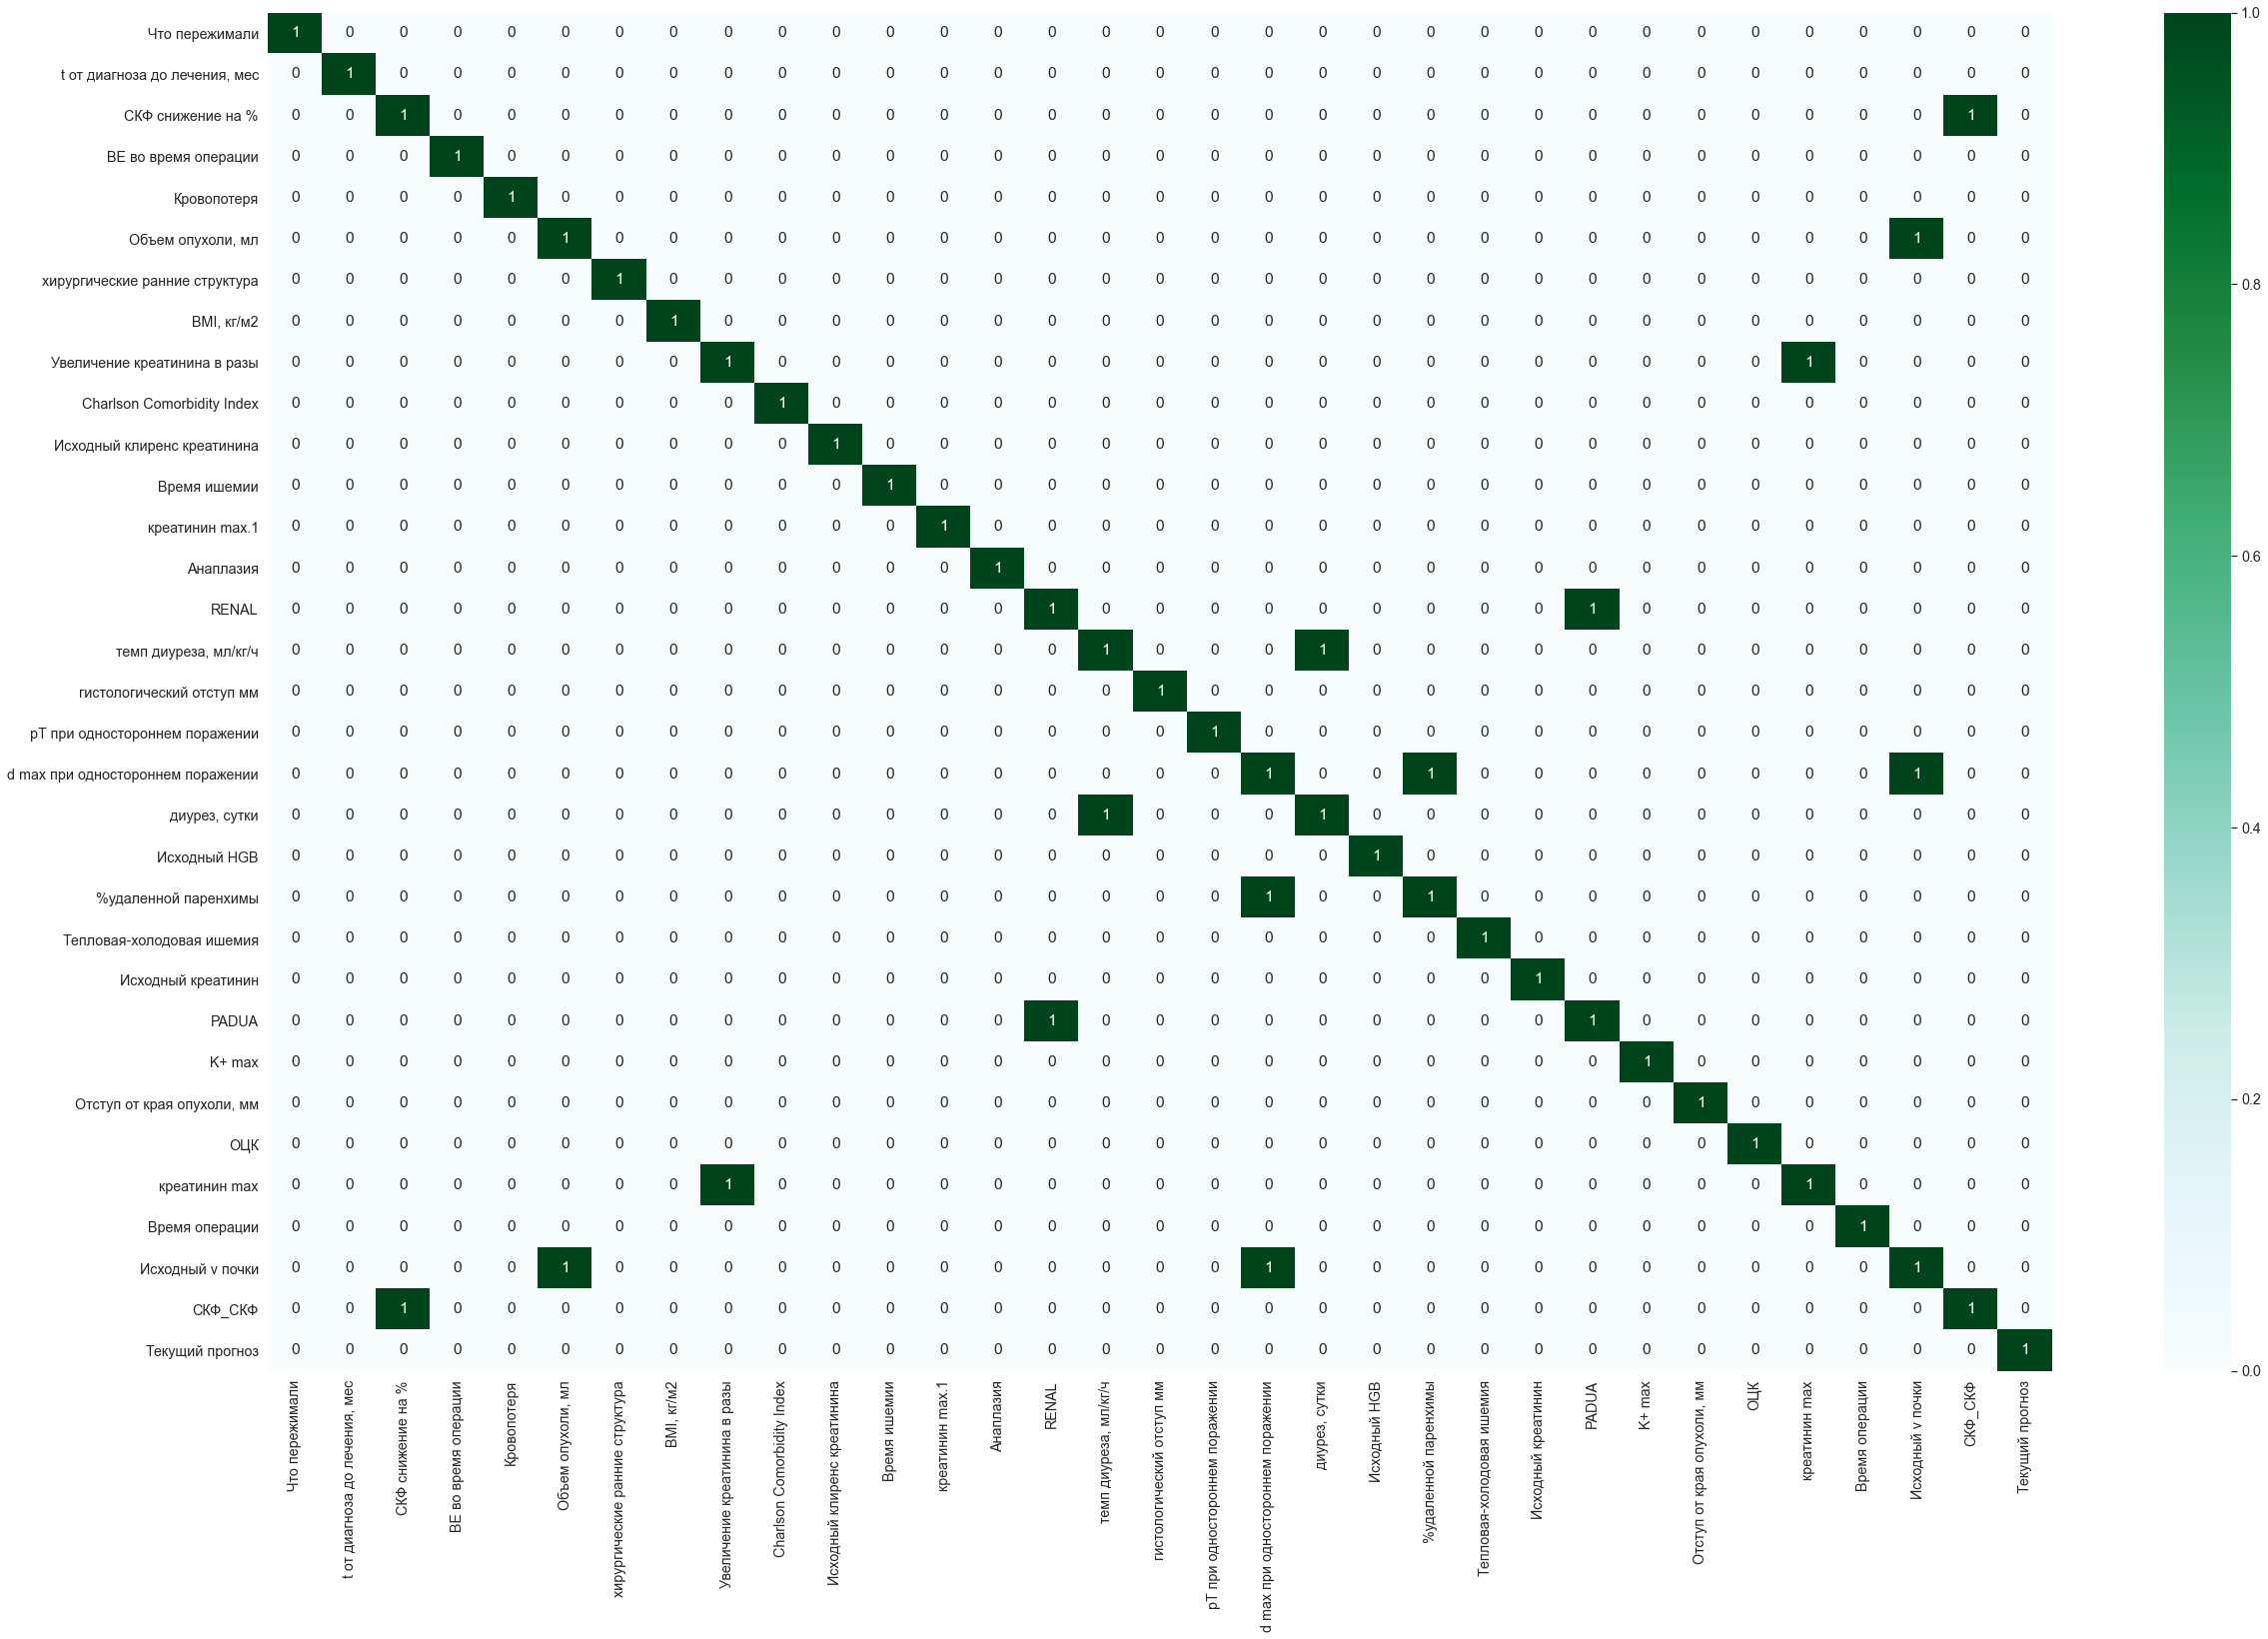

In [54]:
fig, ax = plt.subplots(figsize=(40, 25))
corrmat1 = abs(df1[df_numcol + ['Текущий прогноз']].corr())

sns.heatmap(corrmat1>0.7, vmin=0, vmax=1, annot=True, cmap='BuGn');

In [55]:
# corrmat

**Вывод:** 
1. Признаки `'PADUA'` и `'RENAL'`, а также `'d max при одностороннем поражении'` и `'%удаленной паренхимы'`, `'Вес, кг'` и `'BMI, кг/м2'`, `'Объем опухоли, мл'` и `'Исходный v почки'`, `'рост2, м2'` и `'Рост, см'`, `'СКФ'` и `'СКФ.1'`, `'креатинин max'` и `'Увеличение креатинина в разы'`, `'темп диуреза, мл/кг/ч'` и `'диурез, сутки'` сильно скоррелированы друг с другом, поэтому удалим следующие признаки: `'PADUA'`, `'%удаленной паренхимы'`, `'Вес, кг'`, `'Исходный v почки'`, `'рост2, м2'`, `'СКФ.1'`, `'креатинин max'`, `'диурез, сутки'`;
2. У числовых признаков нет сильной корреляции с таргетом.

In [56]:
# df.drop(['PADUA', '%удаленной паренхимы', 'Вес, кг', 'Исходный v почки', 'рост2, м2',\
#          'СКФ', 'креатинин max', 'диурез, сутки'], 1, inplace=True)
# test.drop(['PADUA', '%удаленной паренхимы', 'Вес, кг', 'Исходный v почки', 'рост2, м2',\
#            'СКФ', 'креатинин max', 'диурез, сутки'], 1, inplace=True)
# df_numcol = list(set(df_numcol) - set(['PADUA', '%удаленной паренхимы', 'Вес, кг', 'Исходный v почки',\
#                                        'рост2, м2', 'СКФ', 'креатинин max', 'диурез, сутки']))
# test_numcol = list(set(df_numcol) - set(['PADUA', '%удаленной паренхимы', 'Вес, кг', 'Исходный v почки',\
#                                        'рост2, м2', 'СКФ', 'креатинин max', 'диурез, сутки']))

In [57]:
df1.drop(['PADUA', '%удаленной паренхимы', 'Исходный v почки',\
         'СКФ_СКФ', 'креатинин max', 'диурез, сутки'], 1, inplace=True)
df_numcol = list(set(df_numcol) - set(['PADUA', '%удаленной паренхимы', 'Вес, кг', 'Исходный v почки',\
                                       'рост2, м2', 'СКФ', 'креатинин max', 'диурез, сутки']))


In [58]:
df_numcol.remove('СКФ_СКФ')

In [59]:
# df.drop('СКФ.1', 1, inplace=True)
# test.drop('СКФ.1', 1, inplace=True)
# df_numcol = list(set(df_numcol) - set(['СКФ.1']))
# test_numcol = list(set(df_numcol) - set(['СКФ.1']))

### Значимость числовых переменных

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

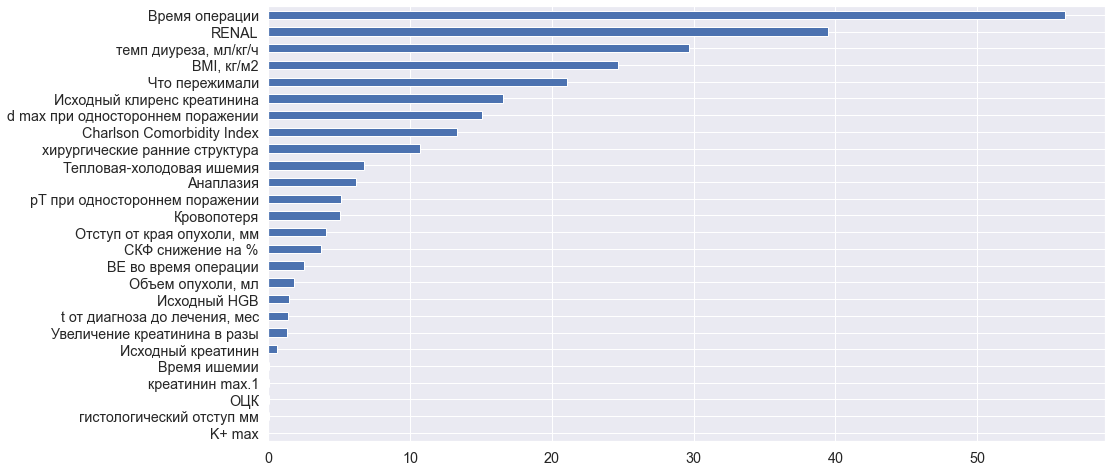

In [60]:
fig, ax = plt.subplots(figsize=(15,8))
imp_num = pd.Series(f_classif(df1[df_numcol], df1['Текущий прогноз'])[0], index=df_numcol)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

**Выводы:** Признаки `'K+ max'` и `'ОЦК'` - незначимые признаки

In [61]:
df1.drop(['Время ишемии', 'креатинин max.1', 'ОЦК', 'гистологический отступ мм', 'K+ max'], 1, inplace=True)

### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

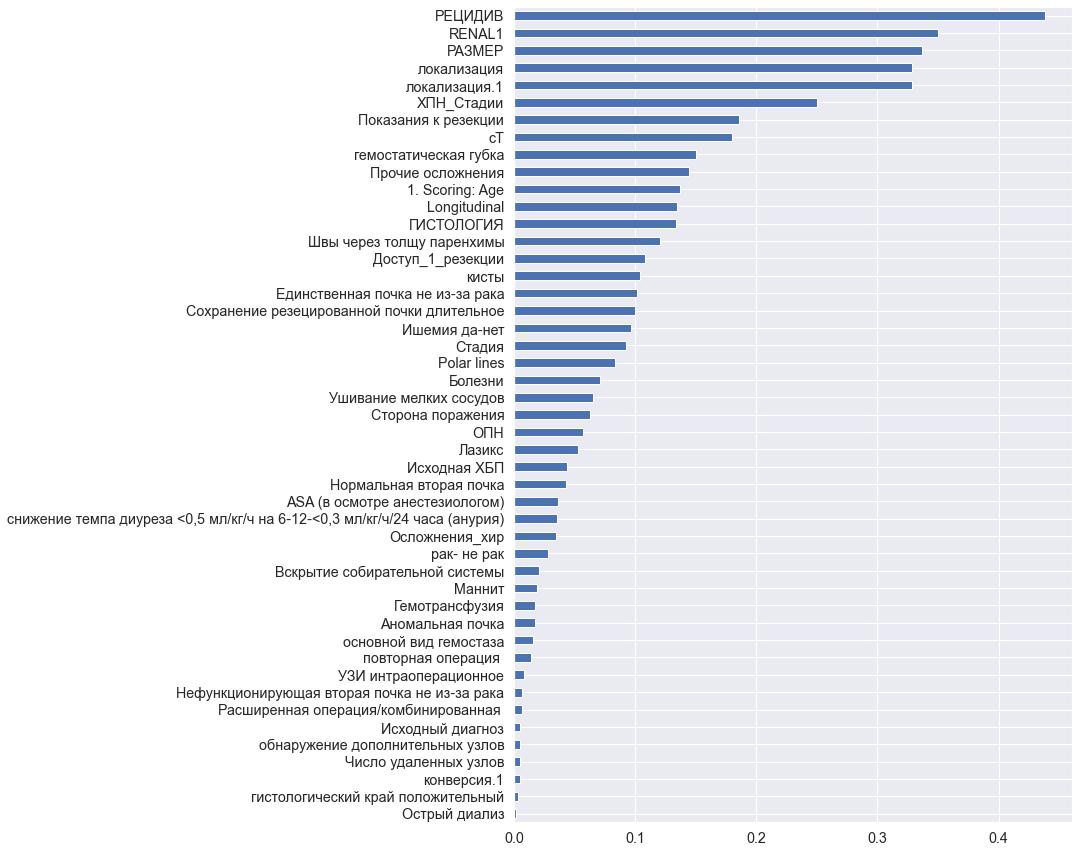

In [62]:
fig, ax = plt.subplots(figsize=(10,15))
imp_cat = pd.Series(mutual_info_classif(df1[df_bcol + df_catcol], df1['Текущий прогноз'],
                                        discrete_features=True), index=df_bcol + df_catcol)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

**Выводы:** Признаки  - незначимые признаки

<a id="4"></a>
# 4. MODEL

####   Выделим тестовую и тренировочную части

In [63]:
X = df1.drop('Текущий прогноз', axis=1)
y = df1['Текущий прогноз']

X.shape, y.shape

((259, 68), (259,))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((207, 68), (52, 68), (207,), (52,))

In [65]:
# для target 'Текущий прогноз'
model_0 = CatBoostClassifier(auto_class_weights='Balanced', 
                          random_seed = RANDOM_SEED,
                          custom_metric='Accuracy',
                          boosting_type="Ordered", learning_rate=0.1,
                          silent=True)
model_0.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         early_stopping_rounds=20,
         use_best_model=True,
         )

# оцениваем точность
predict_0 = model_0.predict(X_test)
print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_0))*100:0.2f}%")
# Точность модели по метрике balanced_accuracy_score:97.98%

Точность модели по метрике balanced_accuracy_score:98.99%


In [66]:
import time 
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [67]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 16.25it/s]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearSVC                          0.98               0.99    None      0.98   
XGBClassifier                      0.98               0.99    None      0.98   
SVC                                0.98               0.99    None      0.98   
RandomForestClassifier             0.98               0.99    None      0.98   
ExtraTreesClassifier               0.98               0.99    None      0.98   
KNeighborsClassifier               0.96               0.98    None      0.96   
PassiveAggressiveClassifier        0.96               0.98    None      0.96   
LogisticRegression                 0.96               0.98    None      0.96   
LGBMClassifier                     0.96               0.98    None      0.96   
NearestCentroid                    0.94               0.97    None      0.94   
BernoulliNB                        0.94               0.97    None      0.94   
GaussianNB                         0.96               0.97    None      0.96   
SGDClassifier                      0.96               0.97    None      0.96   
Perceptron                         0.96               0.97    None      0.96   
BaggingClassifier                  0.96               0.97    None      0.96   
RidgeClassifier                    0.94               0.94    None      0.94   
RidgeClassifierCV                  0.94               0.94    None      0.94   
LinearDiscriminantAnalysis         0.94               0.94    None      0.94   
CalibratedClassifierCV             0.98               0.93    None      0.98   
DecisionTreeClassifier             0.90               0.92    None      0.91   
ExtraTreeClassifier                0.94               0.91    None      0.94   
LabelPropagation                   0.90               0.89    None      0.90   
LabelSpreading                     0.90               0.89    None      0.90   
QuadraticDiscriminantAnalysis      0.92               0.83    None      0.92   
AdaBoostClassifier                 0.63               0.33    None      0.49   
DummyClassifier                    0.46               0.27    None      0.44   

                               Time Taken  
Model                                      
LinearSVC                            0.03  
XGBClassifier                        0.16  
SVC                                  0.03  
RandomForestClassifier               0.25  
ExtraTreesClassifier                 0.20  
KNeighborsClassifier                 0.03  
PassiveAggressiveClassifier          0.06  
LogisticRegression                   0.04  
LGBMClassifier                       0.21  
NearestCentroid                      0.02  
BernoulliNB                          0.02  
GaussianNB                           0.03  
SGDClassifier                        0.03  
Perceptron                           0.05  
BaggingClassifier                    0.07  
RidgeClassifier                      0.03  
RidgeClassifierCV                    0.03  
LinearDiscriminantAnalysis           0.03  
CalibratedClassifierCV               0.11  
DecisionTreeClassifier               0.03  
ExtraTreeClassifier                  0.02  
LabelPropagation                     0.03  
LabelSpreading                       0.03  
QuadraticDiscriminantAnalysis        0.03  
AdaBoostClassifier                   0.17  
DummyClassifier                      0.02

In [70]:
# from sklearn.ensemble import AdaBoostClassifier
# # Построим модель на дефолтных параметрах
# model_2 = AdaBoostClassifier(random_state = RANDOM_SEED)
# model_2.fit(X_train, y_train)

# # оцениваем точность
# predict_2 = model_2.predict(X_test)
# print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_2))*100:0.2f}%")
# # Точность модели по метрике balanced_accuracy_score:98.99%

In [71]:
from sklearn.ensemble import RandomForestClassifier
# Построим модель на дефолтных параметрах
model_3 = RandomForestClassifier(n_estimators=300, random_state = RANDOM_SEED)
model_3.fit(X_train, y_train)
predict_3 = model_3.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_3))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:97.98%
#Точность модели по метрике balanced_accuracy_score:100.00%

Точность модели по метрике balanced_accuracy_score:100.00%


In [72]:
from sklearn.linear_model import LogisticRegression
# Построим модель на дефолтных параметрах
model_4 = LogisticRegression(random_state = RANDOM_SEED)
model_4.fit(X_train, y_train)
predict_4 = model_4.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_4))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:86.91%
#Точность модели по метрике balanced_accuracy_score:89.94%

Точность модели по метрике balanced_accuracy_score:89.94%


In [73]:
from sklearn.ensemble import ExtraTreesClassifier
# Построим модель на дефолтных параметрах
model_5 = ExtraTreesClassifier(n_estimators=150, max_depth=6, random_state = RANDOM_SEED)
model_5.fit(X_train, y_train)
predict_5 = model_5.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_5))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:98.99%
#Точность модели по метрике balanced_accuracy_score:100.00%

Точность модели по метрике balanced_accuracy_score:100.00%


In [74]:
from xgboost import XGBClassifier
# Построим модель на дефолтных параметрах
model_6 = ExtraTreesClassifier(random_state = RANDOM_SEED)
model_6.fit(X_train, y_train)
predict_6 = model_6.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_6))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:98.99%


Точность модели по метрике balanced_accuracy_score:98.99%


In [75]:
from sklearn.ensemble import BaggingClassifier
# Построим модель на дефолтных параметрах
model_7 = BaggingClassifier(random_state = RANDOM_SEED)
model_7.fit(X_train, y_train)
predict_7 = model_7.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_7))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:97.98%
#Точность модели по метрике balanced_accuracy_score:96.61%

Точность модели по метрике balanced_accuracy_score:96.61%


In [76]:
from sklearn.ensemble import StackingClassifier
estimators = [('model_3', RandomForestClassifier(random_state = RANDOM_SEED)),
              ('model_0', CatBoostClassifier(random_seed = RANDOM_SEED))]

st_ensemble = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())

# оцениваем точность
st_ensemble.fit(X_train, y_train)
predict = st_ensemble.predict(X_test)

print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict))*100:0.2f}%")
#Точность модели по метрике balanced_accuracy_score:98.99%

Learning rate set to 0.073019
0:	learn: 1.0167942	total: 47ms	remaining: 47s
1:	learn: 0.9665557	total: 60.1ms	remaining: 30s
2:	learn: 0.9107175	total: 71.8ms	remaining: 23.9s
3:	learn: 0.8537140	total: 83.5ms	remaining: 20.8s
4:	learn: 0.8003280	total: 95.5ms	remaining: 19s
5:	learn: 0.7618276	total: 107ms	remaining: 17.7s
6:	learn: 0.7094007	total: 119ms	remaining: 16.9s
7:	learn: 0.6713228	total: 131ms	remaining: 16.2s
8:	learn: 0.6381427	total: 143ms	remaining: 15.7s
9:	learn: 0.6064558	total: 154ms	remaining: 15.3s
10:	learn: 0.5800646	total: 166ms	remaining: 14.9s
11:	learn: 0.5548928	total: 194ms	remaining: 16s
12:	learn: 0.5296141	total: 207ms	remaining: 15.7s
13:	learn: 0.5015914	total: 220ms	remaining: 15.5s
14:	learn: 0.4828157	total: 234ms	remaining: 15.4s
15:	learn: 0.4641848	total: 246ms	remaining: 15.2s
16:	learn: 0.4405242	total: 261ms	remaining: 15.1s
17:	learn: 0.4220562	total: 273ms	remaining: 14.9s
18:	learn: 0.4066499	total: 285ms	remaining: 14.7s
19:	learn: 0.389

162:	learn: 0.0301004	total: 2.33s	remaining: 12s
163:	learn: 0.0298513	total: 2.35s	remaining: 12s
164:	learn: 0.0294815	total: 2.36s	remaining: 12s
165:	learn: 0.0292869	total: 2.37s	remaining: 11.9s
166:	learn: 0.0291212	total: 2.39s	remaining: 11.9s
167:	learn: 0.0287926	total: 2.4s	remaining: 11.9s
168:	learn: 0.0285590	total: 2.41s	remaining: 11.9s
169:	learn: 0.0283782	total: 2.42s	remaining: 11.8s
170:	learn: 0.0280165	total: 2.43s	remaining: 11.8s
171:	learn: 0.0277403	total: 2.45s	remaining: 11.8s
172:	learn: 0.0275092	total: 2.46s	remaining: 11.7s
173:	learn: 0.0273454	total: 2.47s	remaining: 11.7s
174:	learn: 0.0271689	total: 2.48s	remaining: 11.7s
175:	learn: 0.0269629	total: 2.49s	remaining: 11.7s
176:	learn: 0.0267630	total: 2.52s	remaining: 11.7s
177:	learn: 0.0266012	total: 2.53s	remaining: 11.7s
178:	learn: 0.0264650	total: 2.54s	remaining: 11.7s
179:	learn: 0.0263331	total: 2.55s	remaining: 11.6s
180:	learn: 0.0261651	total: 2.56s	remaining: 11.6s
181:	learn: 0.02597

328:	learn: 0.0120329	total: 4.53s	remaining: 9.23s
329:	learn: 0.0119973	total: 4.55s	remaining: 9.23s
330:	learn: 0.0119586	total: 4.56s	remaining: 9.21s
331:	learn: 0.0119323	total: 4.57s	remaining: 9.2s
332:	learn: 0.0118925	total: 4.58s	remaining: 9.18s
333:	learn: 0.0118447	total: 4.59s	remaining: 9.16s
334:	learn: 0.0117937	total: 4.61s	remaining: 9.14s
335:	learn: 0.0117620	total: 4.62s	remaining: 9.13s
336:	learn: 0.0117248	total: 4.63s	remaining: 9.11s
337:	learn: 0.0116686	total: 4.64s	remaining: 9.09s
338:	learn: 0.0116157	total: 4.65s	remaining: 9.07s
339:	learn: 0.0115845	total: 4.66s	remaining: 9.05s
340:	learn: 0.0115299	total: 4.68s	remaining: 9.04s
341:	learn: 0.0115033	total: 4.7s	remaining: 9.04s
342:	learn: 0.0114619	total: 4.71s	remaining: 9.03s
343:	learn: 0.0114223	total: 4.72s	remaining: 9.01s
344:	learn: 0.0113676	total: 4.74s	remaining: 8.99s
345:	learn: 0.0113045	total: 4.75s	remaining: 8.97s
346:	learn: 0.0112596	total: 4.76s	remaining: 8.96s
347:	learn: 0.

497:	learn: 0.0072866	total: 6.9s	remaining: 6.96s
498:	learn: 0.0072756	total: 6.92s	remaining: 6.95s
499:	learn: 0.0072532	total: 6.93s	remaining: 6.93s
500:	learn: 0.0072368	total: 6.95s	remaining: 6.92s
501:	learn: 0.0072175	total: 6.96s	remaining: 6.9s
502:	learn: 0.0072058	total: 6.97s	remaining: 6.89s
503:	learn: 0.0071908	total: 6.98s	remaining: 6.87s
504:	learn: 0.0071738	total: 6.99s	remaining: 6.85s
505:	learn: 0.0071536	total: 7s	remaining: 6.84s
506:	learn: 0.0071373	total: 7.02s	remaining: 6.82s
507:	learn: 0.0071154	total: 7.03s	remaining: 6.81s
508:	learn: 0.0071023	total: 7.04s	remaining: 6.79s
509:	learn: 0.0070847	total: 7.05s	remaining: 6.77s
510:	learn: 0.0070677	total: 7.06s	remaining: 6.76s
511:	learn: 0.0070510	total: 7.08s	remaining: 6.75s
512:	learn: 0.0070381	total: 7.1s	remaining: 6.74s
513:	learn: 0.0070236	total: 7.11s	remaining: 6.72s
514:	learn: 0.0070040	total: 7.12s	remaining: 6.71s
515:	learn: 0.0069878	total: 7.14s	remaining: 6.69s
516:	learn: 0.0069

661:	learn: 0.0052805	total: 9.03s	remaining: 4.61s
662:	learn: 0.0052694	total: 9.05s	remaining: 4.6s
663:	learn: 0.0052618	total: 9.06s	remaining: 4.58s
664:	learn: 0.0052533	total: 9.07s	remaining: 4.57s
665:	learn: 0.0052422	total: 9.08s	remaining: 4.55s
666:	learn: 0.0052318	total: 9.1s	remaining: 4.54s
667:	learn: 0.0052215	total: 9.11s	remaining: 4.53s
668:	learn: 0.0052087	total: 9.13s	remaining: 4.52s
669:	learn: 0.0051997	total: 9.15s	remaining: 4.5s
670:	learn: 0.0051911	total: 9.16s	remaining: 4.49s
671:	learn: 0.0051756	total: 9.17s	remaining: 4.48s
672:	learn: 0.0051667	total: 9.18s	remaining: 4.46s
673:	learn: 0.0051612	total: 9.21s	remaining: 4.45s
674:	learn: 0.0051518	total: 9.22s	remaining: 4.44s
675:	learn: 0.0051465	total: 9.23s	remaining: 4.42s
676:	learn: 0.0051369	total: 9.24s	remaining: 4.41s
677:	learn: 0.0051265	total: 9.25s	remaining: 4.39s
678:	learn: 0.0051174	total: 9.27s	remaining: 4.38s
679:	learn: 0.0051080	total: 9.28s	remaining: 4.37s
680:	learn: 0.0

822:	learn: 0.0041447	total: 11.2s	remaining: 2.4s
823:	learn: 0.0041406	total: 11.2s	remaining: 2.39s
824:	learn: 0.0041318	total: 11.2s	remaining: 2.38s
825:	learn: 0.0041260	total: 11.2s	remaining: 2.37s
826:	learn: 0.0041215	total: 11.3s	remaining: 2.35s
827:	learn: 0.0041159	total: 11.3s	remaining: 2.34s
828:	learn: 0.0041111	total: 11.3s	remaining: 2.33s
829:	learn: 0.0041055	total: 11.3s	remaining: 2.31s
830:	learn: 0.0041001	total: 11.3s	remaining: 2.3s
831:	learn: 0.0040947	total: 11.3s	remaining: 2.28s
832:	learn: 0.0040904	total: 11.3s	remaining: 2.27s
833:	learn: 0.0040853	total: 11.3s	remaining: 2.26s
834:	learn: 0.0040798	total: 11.3s	remaining: 2.24s
835:	learn: 0.0040724	total: 11.4s	remaining: 2.23s
836:	learn: 0.0040679	total: 11.4s	remaining: 2.22s
837:	learn: 0.0040635	total: 11.4s	remaining: 2.2s
838:	learn: 0.0040596	total: 11.4s	remaining: 2.19s
839:	learn: 0.0040554	total: 11.4s	remaining: 2.17s
840:	learn: 0.0040493	total: 11.4s	remaining: 2.16s
841:	learn: 0.0

990:	learn: 0.0034099	total: 13.4s	remaining: 121ms
991:	learn: 0.0034077	total: 13.4s	remaining: 108ms
992:	learn: 0.0034048	total: 13.4s	remaining: 94.4ms
993:	learn: 0.0034017	total: 13.4s	remaining: 80.9ms
994:	learn: 0.0033984	total: 13.4s	remaining: 67.4ms
995:	learn: 0.0033937	total: 13.4s	remaining: 53.9ms
996:	learn: 0.0033891	total: 13.4s	remaining: 40.4ms
997:	learn: 0.0033844	total: 13.5s	remaining: 27ms
998:	learn: 0.0033810	total: 13.5s	remaining: 13.5ms
999:	learn: 0.0033780	total: 13.5s	remaining: 0us
Learning rate set to 0.07218
0:	learn: 1.0272093	total: 20.8ms	remaining: 20.8s
1:	learn: 0.9626073	total: 32.2ms	remaining: 16s
2:	learn: 0.9199539	total: 42ms	remaining: 14s
3:	learn: 0.8783840	total: 52.1ms	remaining: 13s
4:	learn: 0.8347485	total: 62.5ms	remaining: 12.4s
5:	learn: 0.7941003	total: 73.3ms	remaining: 12.1s
6:	learn: 0.7484090	total: 83.4ms	remaining: 11.8s
7:	learn: 0.7180440	total: 93.9ms	remaining: 11.6s
8:	learn: 0.6761894	total: 104ms	remaining: 11.5

153:	learn: 0.0398979	total: 1.78s	remaining: 9.79s
154:	learn: 0.0395218	total: 1.8s	remaining: 9.82s
155:	learn: 0.0392926	total: 1.81s	remaining: 9.8s
156:	learn: 0.0390356	total: 1.82s	remaining: 9.79s
157:	learn: 0.0387003	total: 1.83s	remaining: 9.77s
158:	learn: 0.0384151	total: 1.84s	remaining: 9.75s
159:	learn: 0.0380760	total: 1.85s	remaining: 9.73s
160:	learn: 0.0377378	total: 1.86s	remaining: 9.71s
161:	learn: 0.0373495	total: 1.87s	remaining: 9.69s
162:	learn: 0.0370385	total: 1.88s	remaining: 9.67s
163:	learn: 0.0367383	total: 1.89s	remaining: 9.65s
164:	learn: 0.0364497	total: 1.9s	remaining: 9.63s
165:	learn: 0.0362101	total: 1.91s	remaining: 9.61s
166:	learn: 0.0358451	total: 1.92s	remaining: 9.59s
167:	learn: 0.0356514	total: 1.93s	remaining: 9.57s
168:	learn: 0.0353761	total: 1.94s	remaining: 9.55s
169:	learn: 0.0350972	total: 1.96s	remaining: 9.59s
170:	learn: 0.0348500	total: 1.98s	remaining: 9.58s
171:	learn: 0.0345906	total: 1.99s	remaining: 9.56s
172:	learn: 0.0

316:	learn: 0.0152343	total: 3.59s	remaining: 7.73s
317:	learn: 0.0151868	total: 3.6s	remaining: 7.73s
318:	learn: 0.0151394	total: 3.62s	remaining: 7.72s
319:	learn: 0.0150828	total: 3.63s	remaining: 7.7s
320:	learn: 0.0150186	total: 3.63s	remaining: 7.69s
321:	learn: 0.0149635	total: 3.65s	remaining: 7.67s
322:	learn: 0.0149020	total: 3.65s	remaining: 7.66s
323:	learn: 0.0148430	total: 3.67s	remaining: 7.65s
324:	learn: 0.0147950	total: 3.67s	remaining: 7.63s
325:	learn: 0.0147429	total: 3.69s	remaining: 7.62s
326:	learn: 0.0146979	total: 3.7s	remaining: 7.61s
327:	learn: 0.0146451	total: 3.71s	remaining: 7.6s
328:	learn: 0.0145881	total: 3.72s	remaining: 7.58s
329:	learn: 0.0145341	total: 3.73s	remaining: 7.57s
330:	learn: 0.0144479	total: 3.74s	remaining: 7.55s
331:	learn: 0.0143872	total: 3.75s	remaining: 7.54s
332:	learn: 0.0143278	total: 3.77s	remaining: 7.55s
333:	learn: 0.0142837	total: 3.78s	remaining: 7.54s
334:	learn: 0.0142289	total: 3.79s	remaining: 7.52s
335:	learn: 0.01

476:	learn: 0.0092164	total: 5.37s	remaining: 5.89s
477:	learn: 0.0091977	total: 5.39s	remaining: 5.89s
478:	learn: 0.0091803	total: 5.41s	remaining: 5.88s
479:	learn: 0.0091595	total: 5.42s	remaining: 5.87s
480:	learn: 0.0091405	total: 5.42s	remaining: 5.85s
481:	learn: 0.0091096	total: 5.44s	remaining: 5.84s
482:	learn: 0.0090835	total: 5.45s	remaining: 5.83s
483:	learn: 0.0090638	total: 5.46s	remaining: 5.82s
484:	learn: 0.0090466	total: 5.47s	remaining: 5.8s
485:	learn: 0.0090199	total: 5.48s	remaining: 5.79s
486:	learn: 0.0089863	total: 5.49s	remaining: 5.78s
487:	learn: 0.0089679	total: 5.5s	remaining: 5.77s
488:	learn: 0.0089429	total: 5.51s	remaining: 5.75s
489:	learn: 0.0089204	total: 5.52s	remaining: 5.74s
490:	learn: 0.0089041	total: 5.53s	remaining: 5.73s
491:	learn: 0.0088790	total: 5.54s	remaining: 5.72s
492:	learn: 0.0088505	total: 5.56s	remaining: 5.71s
493:	learn: 0.0088173	total: 5.57s	remaining: 5.71s
494:	learn: 0.0088004	total: 5.58s	remaining: 5.7s
495:	learn: 0.0

636:	learn: 0.0064883	total: 7.15s	remaining: 4.08s
637:	learn: 0.0064784	total: 7.17s	remaining: 4.07s
638:	learn: 0.0064701	total: 7.18s	remaining: 4.06s
639:	learn: 0.0064601	total: 7.19s	remaining: 4.04s
640:	learn: 0.0064426	total: 7.2s	remaining: 4.03s
641:	learn: 0.0064286	total: 7.21s	remaining: 4.02s
642:	learn: 0.0064202	total: 7.22s	remaining: 4.01s
643:	learn: 0.0064063	total: 7.23s	remaining: 4s
644:	learn: 0.0063925	total: 7.24s	remaining: 3.98s
645:	learn: 0.0063830	total: 7.25s	remaining: 3.97s
646:	learn: 0.0063755	total: 7.26s	remaining: 3.96s
647:	learn: 0.0063639	total: 7.27s	remaining: 3.95s
648:	learn: 0.0063540	total: 7.28s	remaining: 3.94s
649:	learn: 0.0063440	total: 7.29s	remaining: 3.93s
650:	learn: 0.0063339	total: 7.3s	remaining: 3.91s
651:	learn: 0.0063246	total: 7.31s	remaining: 3.9s
652:	learn: 0.0063155	total: 7.33s	remaining: 3.9s
653:	learn: 0.0063046	total: 7.34s	remaining: 3.88s
654:	learn: 0.0062904	total: 7.36s	remaining: 3.87s
655:	learn: 0.00628

796:	learn: 0.0050226	total: 8.92s	remaining: 2.27s
797:	learn: 0.0050150	total: 8.94s	remaining: 2.26s
798:	learn: 0.0050077	total: 8.95s	remaining: 2.25s
799:	learn: 0.0050021	total: 8.96s	remaining: 2.24s
800:	learn: 0.0049975	total: 8.97s	remaining: 2.23s
801:	learn: 0.0049916	total: 8.98s	remaining: 2.22s
802:	learn: 0.0049863	total: 8.99s	remaining: 2.21s
803:	learn: 0.0049788	total: 9s	remaining: 2.19s
804:	learn: 0.0049702	total: 9.01s	remaining: 2.18s
805:	learn: 0.0049630	total: 9.02s	remaining: 2.17s
806:	learn: 0.0049568	total: 9.03s	remaining: 2.16s
807:	learn: 0.0049514	total: 9.04s	remaining: 2.15s
808:	learn: 0.0049435	total: 9.05s	remaining: 2.14s
809:	learn: 0.0049342	total: 9.06s	remaining: 2.13s
810:	learn: 0.0049294	total: 9.07s	remaining: 2.11s
811:	learn: 0.0049231	total: 9.08s	remaining: 2.1s
812:	learn: 0.0049156	total: 9.1s	remaining: 2.09s
813:	learn: 0.0049066	total: 9.11s	remaining: 2.08s
814:	learn: 0.0048998	total: 9.12s	remaining: 2.07s
815:	learn: 0.004

957:	learn: 0.0040665	total: 10.7s	remaining: 469ms
958:	learn: 0.0040620	total: 10.7s	remaining: 458ms
959:	learn: 0.0040537	total: 10.7s	remaining: 447ms
960:	learn: 0.0040504	total: 10.7s	remaining: 436ms
961:	learn: 0.0040451	total: 10.7s	remaining: 424ms
962:	learn: 0.0040405	total: 10.8s	remaining: 413ms
963:	learn: 0.0040374	total: 10.8s	remaining: 402ms
964:	learn: 0.0040329	total: 10.8s	remaining: 391ms
965:	learn: 0.0040279	total: 10.8s	remaining: 380ms
966:	learn: 0.0040244	total: 10.8s	remaining: 368ms
967:	learn: 0.0040199	total: 10.8s	remaining: 357ms
968:	learn: 0.0040165	total: 10.8s	remaining: 346ms
969:	learn: 0.0040103	total: 10.8s	remaining: 335ms
970:	learn: 0.0040026	total: 10.8s	remaining: 324ms
971:	learn: 0.0039995	total: 10.8s	remaining: 312ms
972:	learn: 0.0039933	total: 10.9s	remaining: 301ms
973:	learn: 0.0039889	total: 10.9s	remaining: 290ms
974:	learn: 0.0039843	total: 10.9s	remaining: 279ms
975:	learn: 0.0039799	total: 10.9s	remaining: 268ms
976:	learn: 

132:	learn: 0.0473703	total: 1.45s	remaining: 9.47s
133:	learn: 0.0469043	total: 1.47s	remaining: 9.51s
134:	learn: 0.0464615	total: 1.48s	remaining: 9.51s
135:	learn: 0.0457923	total: 1.49s	remaining: 9.49s
136:	learn: 0.0452201	total: 1.5s	remaining: 9.47s
137:	learn: 0.0448825	total: 1.51s	remaining: 9.46s
138:	learn: 0.0443218	total: 1.52s	remaining: 9.44s
139:	learn: 0.0439886	total: 1.53s	remaining: 9.42s
140:	learn: 0.0435831	total: 1.54s	remaining: 9.4s
141:	learn: 0.0429724	total: 1.55s	remaining: 9.38s
142:	learn: 0.0423809	total: 1.56s	remaining: 9.36s
143:	learn: 0.0421149	total: 1.57s	remaining: 9.35s
144:	learn: 0.0416695	total: 1.58s	remaining: 9.33s
145:	learn: 0.0412684	total: 1.59s	remaining: 9.31s
146:	learn: 0.0408622	total: 1.6s	remaining: 9.29s
147:	learn: 0.0403905	total: 1.61s	remaining: 9.28s
148:	learn: 0.0400701	total: 1.63s	remaining: 9.31s
149:	learn: 0.0397886	total: 1.64s	remaining: 9.31s
150:	learn: 0.0395374	total: 1.65s	remaining: 9.3s
151:	learn: 0.03

294:	learn: 0.0164641	total: 3.22s	remaining: 7.7s
295:	learn: 0.0163957	total: 3.24s	remaining: 7.71s
296:	learn: 0.0163199	total: 3.26s	remaining: 7.72s
297:	learn: 0.0162418	total: 3.27s	remaining: 7.71s
298:	learn: 0.0161822	total: 3.29s	remaining: 7.71s
299:	learn: 0.0161208	total: 3.3s	remaining: 7.69s
300:	learn: 0.0160591	total: 3.31s	remaining: 7.68s
301:	learn: 0.0159952	total: 3.32s	remaining: 7.67s
302:	learn: 0.0159315	total: 3.33s	remaining: 7.66s
303:	learn: 0.0158712	total: 3.34s	remaining: 7.65s
304:	learn: 0.0158086	total: 3.35s	remaining: 7.64s
305:	learn: 0.0157562	total: 3.36s	remaining: 7.62s
306:	learn: 0.0157057	total: 3.37s	remaining: 7.61s
307:	learn: 0.0156298	total: 3.38s	remaining: 7.6s
308:	learn: 0.0155731	total: 3.4s	remaining: 7.6s
309:	learn: 0.0155144	total: 3.41s	remaining: 7.59s
310:	learn: 0.0154662	total: 3.42s	remaining: 7.58s
311:	learn: 0.0153975	total: 3.43s	remaining: 7.57s
312:	learn: 0.0153290	total: 3.44s	remaining: 7.56s
313:	learn: 0.015

456:	learn: 0.0097695	total: 5s	remaining: 5.94s
457:	learn: 0.0097463	total: 5.02s	remaining: 5.94s
458:	learn: 0.0097205	total: 5.03s	remaining: 5.93s
459:	learn: 0.0096952	total: 5.04s	remaining: 5.92s
460:	learn: 0.0096703	total: 5.05s	remaining: 5.91s
461:	learn: 0.0096437	total: 5.06s	remaining: 5.89s
462:	learn: 0.0096256	total: 5.07s	remaining: 5.88s
463:	learn: 0.0096099	total: 5.08s	remaining: 5.87s
464:	learn: 0.0095853	total: 5.09s	remaining: 5.86s
465:	learn: 0.0095623	total: 5.1s	remaining: 5.84s
466:	learn: 0.0095335	total: 5.11s	remaining: 5.83s
467:	learn: 0.0095176	total: 5.12s	remaining: 5.82s
468:	learn: 0.0094977	total: 5.13s	remaining: 5.81s
469:	learn: 0.0094736	total: 5.14s	remaining: 5.8s
470:	learn: 0.0094552	total: 5.15s	remaining: 5.79s
471:	learn: 0.0094343	total: 5.16s	remaining: 5.77s
472:	learn: 0.0094088	total: 5.18s	remaining: 5.77s
473:	learn: 0.0093901	total: 5.19s	remaining: 5.76s
474:	learn: 0.0093736	total: 5.2s	remaining: 5.75s
475:	learn: 0.0093

619:	learn: 0.0069166	total: 6.79s	remaining: 4.16s
620:	learn: 0.0069081	total: 6.8s	remaining: 4.15s
621:	learn: 0.0068912	total: 6.81s	remaining: 4.14s
622:	learn: 0.0068759	total: 6.82s	remaining: 4.13s
623:	learn: 0.0068651	total: 6.84s	remaining: 4.12s
624:	learn: 0.0068518	total: 6.86s	remaining: 4.11s
625:	learn: 0.0068389	total: 6.87s	remaining: 4.1s
626:	learn: 0.0068229	total: 6.88s	remaining: 4.09s
627:	learn: 0.0068119	total: 6.89s	remaining: 4.08s
628:	learn: 0.0067999	total: 6.91s	remaining: 4.07s
629:	learn: 0.0067849	total: 6.92s	remaining: 4.07s
630:	learn: 0.0067733	total: 6.94s	remaining: 4.06s
631:	learn: 0.0067598	total: 6.95s	remaining: 4.05s
632:	learn: 0.0067489	total: 6.98s	remaining: 4.04s
633:	learn: 0.0067314	total: 7s	remaining: 4.04s
634:	learn: 0.0067180	total: 7.01s	remaining: 4.03s
635:	learn: 0.0067034	total: 7.02s	remaining: 4.02s
636:	learn: 0.0066915	total: 7.03s	remaining: 4.01s
637:	learn: 0.0066820	total: 7.04s	remaining: 4s
638:	learn: 0.006672

793:	learn: 0.0052191	total: 8.74s	remaining: 2.27s
794:	learn: 0.0052125	total: 8.76s	remaining: 2.26s
795:	learn: 0.0052018	total: 8.78s	remaining: 2.25s
796:	learn: 0.0051948	total: 8.79s	remaining: 2.24s
797:	learn: 0.0051878	total: 8.8s	remaining: 2.23s
798:	learn: 0.0051797	total: 8.81s	remaining: 2.22s
799:	learn: 0.0051735	total: 8.82s	remaining: 2.21s
800:	learn: 0.0051672	total: 8.83s	remaining: 2.19s
801:	learn: 0.0051606	total: 8.85s	remaining: 2.18s
802:	learn: 0.0051520	total: 8.86s	remaining: 2.17s
803:	learn: 0.0051444	total: 8.87s	remaining: 2.16s
804:	learn: 0.0051388	total: 8.88s	remaining: 2.15s
805:	learn: 0.0051328	total: 8.88s	remaining: 2.14s
806:	learn: 0.0051273	total: 8.89s	remaining: 2.13s
807:	learn: 0.0051202	total: 8.91s	remaining: 2.12s
808:	learn: 0.0051124	total: 8.93s	remaining: 2.11s
809:	learn: 0.0051059	total: 8.94s	remaining: 2.1s
810:	learn: 0.0051014	total: 8.95s	remaining: 2.08s
811:	learn: 0.0050948	total: 8.96s	remaining: 2.07s
812:	learn: 0.

953:	learn: 0.0042674	total: 10.5s	remaining: 508ms
954:	learn: 0.0042627	total: 10.5s	remaining: 497ms
955:	learn: 0.0042584	total: 10.6s	remaining: 486ms
956:	learn: 0.0042529	total: 10.6s	remaining: 475ms
957:	learn: 0.0042486	total: 10.6s	remaining: 464ms
958:	learn: 0.0042436	total: 10.6s	remaining: 453ms
959:	learn: 0.0042404	total: 10.6s	remaining: 442ms
960:	learn: 0.0042362	total: 10.6s	remaining: 430ms
961:	learn: 0.0042319	total: 10.6s	remaining: 419ms
962:	learn: 0.0042279	total: 10.6s	remaining: 408ms
963:	learn: 0.0042220	total: 10.6s	remaining: 397ms
964:	learn: 0.0042157	total: 10.6s	remaining: 386ms
965:	learn: 0.0042103	total: 10.7s	remaining: 375ms
966:	learn: 0.0042025	total: 10.7s	remaining: 364ms
967:	learn: 0.0041985	total: 10.7s	remaining: 353ms
968:	learn: 0.0041917	total: 10.7s	remaining: 342ms
969:	learn: 0.0041874	total: 10.7s	remaining: 331ms
970:	learn: 0.0041845	total: 10.7s	remaining: 320ms
971:	learn: 0.0041796	total: 10.7s	remaining: 309ms
972:	learn: 

113:	learn: 0.0567530	total: 1.26s	remaining: 9.8s
114:	learn: 0.0560689	total: 1.28s	remaining: 9.84s
115:	learn: 0.0551287	total: 1.29s	remaining: 9.82s
116:	learn: 0.0542480	total: 1.3s	remaining: 9.81s
117:	learn: 0.0536194	total: 1.31s	remaining: 9.8s
118:	learn: 0.0527009	total: 1.32s	remaining: 9.78s
119:	learn: 0.0521479	total: 1.33s	remaining: 9.76s
120:	learn: 0.0513886	total: 1.34s	remaining: 9.75s
121:	learn: 0.0508800	total: 1.35s	remaining: 9.74s
122:	learn: 0.0500627	total: 1.36s	remaining: 9.72s
123:	learn: 0.0495137	total: 1.37s	remaining: 9.71s
124:	learn: 0.0489917	total: 1.39s	remaining: 9.71s
125:	learn: 0.0485364	total: 1.4s	remaining: 9.7s
126:	learn: 0.0480336	total: 1.41s	remaining: 9.68s
127:	learn: 0.0475323	total: 1.42s	remaining: 9.66s
128:	learn: 0.0471771	total: 1.44s	remaining: 9.72s
129:	learn: 0.0467385	total: 1.45s	remaining: 9.71s
130:	learn: 0.0461301	total: 1.46s	remaining: 9.69s
131:	learn: 0.0451738	total: 1.47s	remaining: 9.67s
132:	learn: 0.044

285:	learn: 0.0153890	total: 3.21s	remaining: 8.01s
286:	learn: 0.0153401	total: 3.23s	remaining: 8.01s
287:	learn: 0.0152885	total: 3.24s	remaining: 8.01s
288:	learn: 0.0152123	total: 3.25s	remaining: 8s
289:	learn: 0.0151545	total: 3.26s	remaining: 7.98s
290:	learn: 0.0150363	total: 3.27s	remaining: 7.97s
291:	learn: 0.0149521	total: 3.28s	remaining: 7.96s
292:	learn: 0.0148861	total: 3.29s	remaining: 7.94s
293:	learn: 0.0148299	total: 3.3s	remaining: 7.93s
294:	learn: 0.0147885	total: 3.31s	remaining: 7.91s
295:	learn: 0.0147200	total: 3.32s	remaining: 7.9s
296:	learn: 0.0146911	total: 3.33s	remaining: 7.89s
297:	learn: 0.0146424	total: 3.34s	remaining: 7.87s
298:	learn: 0.0145601	total: 3.35s	remaining: 7.86s
299:	learn: 0.0144856	total: 3.36s	remaining: 7.84s
300:	learn: 0.0144201	total: 3.37s	remaining: 7.83s
301:	learn: 0.0143451	total: 3.39s	remaining: 7.84s
302:	learn: 0.0143184	total: 3.4s	remaining: 7.83s
303:	learn: 0.0142813	total: 3.42s	remaining: 7.82s
304:	learn: 0.0142

445:	learn: 0.0090679	total: 4.99s	remaining: 6.2s
446:	learn: 0.0090445	total: 5.01s	remaining: 6.2s
447:	learn: 0.0090058	total: 5.02s	remaining: 6.18s
448:	learn: 0.0089885	total: 5.03s	remaining: 6.17s
449:	learn: 0.0089485	total: 5.04s	remaining: 6.16s
450:	learn: 0.0089207	total: 5.05s	remaining: 6.15s
451:	learn: 0.0089078	total: 5.06s	remaining: 6.14s
452:	learn: 0.0088943	total: 5.07s	remaining: 6.12s
453:	learn: 0.0088763	total: 5.08s	remaining: 6.11s
454:	learn: 0.0088662	total: 5.09s	remaining: 6.1s
455:	learn: 0.0088522	total: 5.1s	remaining: 6.09s
456:	learn: 0.0088275	total: 5.11s	remaining: 6.07s
457:	learn: 0.0088094	total: 5.12s	remaining: 6.06s
458:	learn: 0.0088004	total: 5.13s	remaining: 6.05s
459:	learn: 0.0087752	total: 5.14s	remaining: 6.04s
460:	learn: 0.0087571	total: 5.15s	remaining: 6.02s
461:	learn: 0.0087391	total: 5.17s	remaining: 6.03s
462:	learn: 0.0087183	total: 5.19s	remaining: 6.01s
463:	learn: 0.0087026	total: 5.2s	remaining: 6s
464:	learn: 0.008687

604:	learn: 0.0064591	total: 6.78s	remaining: 4.43s
605:	learn: 0.0064463	total: 6.8s	remaining: 4.42s
606:	learn: 0.0064352	total: 6.81s	remaining: 4.41s
607:	learn: 0.0064282	total: 6.82s	remaining: 4.4s
608:	learn: 0.0064192	total: 6.83s	remaining: 4.39s
609:	learn: 0.0064053	total: 6.84s	remaining: 4.38s
610:	learn: 0.0063958	total: 6.85s	remaining: 4.36s
611:	learn: 0.0063850	total: 6.86s	remaining: 4.35s
612:	learn: 0.0063712	total: 6.87s	remaining: 4.34s
613:	learn: 0.0063613	total: 6.88s	remaining: 4.33s
614:	learn: 0.0063485	total: 6.89s	remaining: 4.32s
615:	learn: 0.0063373	total: 6.9s	remaining: 4.3s
616:	learn: 0.0063272	total: 6.91s	remaining: 4.29s
617:	learn: 0.0063201	total: 6.92s	remaining: 4.28s
618:	learn: 0.0063120	total: 6.93s	remaining: 4.27s
619:	learn: 0.0062928	total: 6.95s	remaining: 4.26s
620:	learn: 0.0062837	total: 6.96s	remaining: 4.25s
621:	learn: 0.0062693	total: 6.97s	remaining: 4.24s
622:	learn: 0.0062565	total: 6.99s	remaining: 4.23s
623:	learn: 0.00

764:	learn: 0.0049719	total: 8.56s	remaining: 2.63s
765:	learn: 0.0049673	total: 8.58s	remaining: 2.62s
766:	learn: 0.0049615	total: 8.59s	remaining: 2.61s
767:	learn: 0.0049555	total: 8.6s	remaining: 2.6s
768:	learn: 0.0049476	total: 8.61s	remaining: 2.59s
769:	learn: 0.0049412	total: 8.62s	remaining: 2.58s
770:	learn: 0.0049330	total: 8.63s	remaining: 2.56s
771:	learn: 0.0049247	total: 8.64s	remaining: 2.55s
772:	learn: 0.0049123	total: 8.65s	remaining: 2.54s
773:	learn: 0.0049057	total: 8.66s	remaining: 2.53s
774:	learn: 0.0048978	total: 8.67s	remaining: 2.52s
775:	learn: 0.0048867	total: 8.68s	remaining: 2.51s
776:	learn: 0.0048836	total: 8.69s	remaining: 2.5s
777:	learn: 0.0048785	total: 8.7s	remaining: 2.48s
778:	learn: 0.0048707	total: 8.71s	remaining: 2.47s
779:	learn: 0.0048642	total: 8.72s	remaining: 2.46s
780:	learn: 0.0048579	total: 8.74s	remaining: 2.45s
781:	learn: 0.0048488	total: 8.76s	remaining: 2.44s
782:	learn: 0.0048425	total: 8.77s	remaining: 2.43s
783:	learn: 0.00

924:	learn: 0.0040085	total: 10.4s	remaining: 839ms
925:	learn: 0.0040042	total: 10.4s	remaining: 829ms
926:	learn: 0.0040008	total: 10.4s	remaining: 817ms
927:	learn: 0.0039951	total: 10.4s	remaining: 806ms
928:	learn: 0.0039905	total: 10.4s	remaining: 795ms
929:	learn: 0.0039863	total: 10.4s	remaining: 784ms
930:	learn: 0.0039815	total: 10.4s	remaining: 772ms
931:	learn: 0.0039776	total: 10.4s	remaining: 761ms
932:	learn: 0.0039688	total: 10.4s	remaining: 750ms
933:	learn: 0.0039639	total: 10.5s	remaining: 739ms
934:	learn: 0.0039602	total: 10.5s	remaining: 727ms
935:	learn: 0.0039577	total: 10.5s	remaining: 716ms
936:	learn: 0.0039544	total: 10.5s	remaining: 705ms
937:	learn: 0.0039496	total: 10.5s	remaining: 694ms
938:	learn: 0.0039454	total: 10.5s	remaining: 682ms
939:	learn: 0.0039411	total: 10.5s	remaining: 671ms
940:	learn: 0.0039343	total: 10.5s	remaining: 660ms
941:	learn: 0.0039319	total: 10.5s	remaining: 649ms
942:	learn: 0.0039260	total: 10.6s	remaining: 638ms
943:	learn: 

89:	learn: 0.0737675	total: 1.08s	remaining: 10.9s
90:	learn: 0.0728319	total: 1.1s	remaining: 11s
91:	learn: 0.0717378	total: 1.11s	remaining: 11s
92:	learn: 0.0705853	total: 1.12s	remaining: 11s
93:	learn: 0.0695570	total: 1.14s	remaining: 10.9s
94:	learn: 0.0686648	total: 1.15s	remaining: 10.9s
95:	learn: 0.0678929	total: 1.16s	remaining: 10.9s
96:	learn: 0.0669807	total: 1.17s	remaining: 10.9s
97:	learn: 0.0662700	total: 1.18s	remaining: 10.8s
98:	learn: 0.0652161	total: 1.19s	remaining: 10.8s
99:	learn: 0.0640169	total: 1.2s	remaining: 10.8s
100:	learn: 0.0633998	total: 1.21s	remaining: 10.8s
101:	learn: 0.0624274	total: 1.22s	remaining: 10.8s
102:	learn: 0.0614532	total: 1.23s	remaining: 10.8s
103:	learn: 0.0606440	total: 1.25s	remaining: 10.7s
104:	learn: 0.0600669	total: 1.27s	remaining: 10.8s
105:	learn: 0.0591581	total: 1.28s	remaining: 10.8s
106:	learn: 0.0581681	total: 1.29s	remaining: 10.8s
107:	learn: 0.0572998	total: 1.3s	remaining: 10.8s
108:	learn: 0.0566312	total: 1.3

252:	learn: 0.0184195	total: 3.04s	remaining: 8.98s
253:	learn: 0.0183131	total: 3.06s	remaining: 8.99s
254:	learn: 0.0182423	total: 3.07s	remaining: 8.98s
255:	learn: 0.0181391	total: 3.08s	remaining: 8.96s
256:	learn: 0.0180326	total: 3.1s	remaining: 8.95s
257:	learn: 0.0179456	total: 3.11s	remaining: 8.93s
258:	learn: 0.0178790	total: 3.12s	remaining: 8.92s
259:	learn: 0.0178033	total: 3.13s	remaining: 8.9s
260:	learn: 0.0177418	total: 3.14s	remaining: 8.89s
261:	learn: 0.0176449	total: 3.15s	remaining: 8.87s
262:	learn: 0.0175677	total: 3.16s	remaining: 8.86s
263:	learn: 0.0174946	total: 3.17s	remaining: 8.84s
264:	learn: 0.0174168	total: 3.18s	remaining: 8.83s
265:	learn: 0.0173239	total: 3.19s	remaining: 8.81s
266:	learn: 0.0172436	total: 3.21s	remaining: 8.8s
267:	learn: 0.0171794	total: 3.23s	remaining: 8.81s
268:	learn: 0.0170732	total: 3.24s	remaining: 8.8s
269:	learn: 0.0170138	total: 3.25s	remaining: 8.79s
270:	learn: 0.0169391	total: 3.26s	remaining: 8.77s
271:	learn: 0.01

417:	learn: 0.0100751	total: 5.03s	remaining: 7s
418:	learn: 0.0100475	total: 5.05s	remaining: 7s
419:	learn: 0.0100262	total: 5.06s	remaining: 6.99s
420:	learn: 0.0099941	total: 5.07s	remaining: 6.97s
421:	learn: 0.0099702	total: 5.08s	remaining: 6.96s
422:	learn: 0.0099317	total: 5.09s	remaining: 6.95s
423:	learn: 0.0098803	total: 5.1s	remaining: 6.93s
424:	learn: 0.0098505	total: 5.11s	remaining: 6.92s
425:	learn: 0.0098263	total: 5.13s	remaining: 6.91s
426:	learn: 0.0098019	total: 5.14s	remaining: 6.89s
427:	learn: 0.0097671	total: 5.15s	remaining: 6.88s
428:	learn: 0.0097463	total: 5.16s	remaining: 6.87s
429:	learn: 0.0097215	total: 5.17s	remaining: 6.85s
430:	learn: 0.0096868	total: 5.18s	remaining: 6.84s
431:	learn: 0.0096672	total: 5.19s	remaining: 6.83s
432:	learn: 0.0096380	total: 5.21s	remaining: 6.83s
433:	learn: 0.0096086	total: 5.23s	remaining: 6.82s
434:	learn: 0.0095827	total: 5.24s	remaining: 6.8s
435:	learn: 0.0095580	total: 5.25s	remaining: 6.79s
436:	learn: 0.009529

579:	learn: 0.0068037	total: 6.98s	remaining: 5.06s
580:	learn: 0.0067915	total: 7s	remaining: 5.05s
581:	learn: 0.0067685	total: 7.01s	remaining: 5.04s
582:	learn: 0.0067561	total: 7.02s	remaining: 5.02s
583:	learn: 0.0067440	total: 7.03s	remaining: 5.01s
584:	learn: 0.0067288	total: 7.04s	remaining: 5s
585:	learn: 0.0067169	total: 7.06s	remaining: 4.99s
586:	learn: 0.0067028	total: 7.07s	remaining: 4.97s
587:	learn: 0.0066892	total: 7.08s	remaining: 4.96s
588:	learn: 0.0066753	total: 7.09s	remaining: 4.95s
589:	learn: 0.0066625	total: 7.1s	remaining: 4.93s
590:	learn: 0.0066493	total: 7.11s	remaining: 4.92s
591:	learn: 0.0066365	total: 7.12s	remaining: 4.91s
592:	learn: 0.0066252	total: 7.13s	remaining: 4.89s
593:	learn: 0.0066109	total: 7.14s	remaining: 4.88s
594:	learn: 0.0066014	total: 7.17s	remaining: 4.88s
595:	learn: 0.0065849	total: 7.18s	remaining: 4.87s
596:	learn: 0.0065722	total: 7.19s	remaining: 4.85s
597:	learn: 0.0065597	total: 7.2s	remaining: 4.84s
598:	learn: 0.006551

744:	learn: 0.0051155	total: 8.96s	remaining: 3.07s
745:	learn: 0.0051066	total: 8.98s	remaining: 3.06s
746:	learn: 0.0050986	total: 8.99s	remaining: 3.05s
747:	learn: 0.0050942	total: 9.01s	remaining: 3.03s
748:	learn: 0.0050868	total: 9.02s	remaining: 3.02s
749:	learn: 0.0050811	total: 9.03s	remaining: 3.01s
750:	learn: 0.0050726	total: 9.04s	remaining: 3s
751:	learn: 0.0050646	total: 9.05s	remaining: 2.98s
752:	learn: 0.0050554	total: 9.06s	remaining: 2.97s
753:	learn: 0.0050502	total: 9.07s	remaining: 2.96s
754:	learn: 0.0050447	total: 9.08s	remaining: 2.95s
755:	learn: 0.0050379	total: 9.09s	remaining: 2.94s
756:	learn: 0.0050283	total: 9.1s	remaining: 2.92s
757:	learn: 0.0050213	total: 9.11s	remaining: 2.91s
758:	learn: 0.0050144	total: 9.14s	remaining: 2.9s
759:	learn: 0.0050076	total: 9.15s	remaining: 2.89s
760:	learn: 0.0050012	total: 9.16s	remaining: 2.88s
761:	learn: 0.0049939	total: 9.17s	remaining: 2.87s
762:	learn: 0.0049868	total: 9.18s	remaining: 2.85s
763:	learn: 0.004

917:	learn: 0.0040512	total: 11.1s	remaining: 993ms
918:	learn: 0.0040474	total: 11.1s	remaining: 981ms
919:	learn: 0.0040424	total: 11.1s	remaining: 969ms
920:	learn: 0.0040380	total: 11.2s	remaining: 957ms
921:	learn: 0.0040342	total: 11.2s	remaining: 945ms
922:	learn: 0.0040306	total: 11.2s	remaining: 932ms
923:	learn: 0.0040261	total: 11.2s	remaining: 920ms
924:	learn: 0.0040218	total: 11.2s	remaining: 908ms
925:	learn: 0.0040184	total: 11.2s	remaining: 896ms
926:	learn: 0.0040148	total: 11.2s	remaining: 884ms
927:	learn: 0.0040098	total: 11.2s	remaining: 871ms
928:	learn: 0.0040051	total: 11.2s	remaining: 859ms
929:	learn: 0.0040004	total: 11.3s	remaining: 847ms
930:	learn: 0.0039956	total: 11.3s	remaining: 835ms
931:	learn: 0.0039911	total: 11.3s	remaining: 823ms
932:	learn: 0.0039860	total: 11.3s	remaining: 812ms
933:	learn: 0.0039817	total: 11.3s	remaining: 799ms
934:	learn: 0.0039783	total: 11.3s	remaining: 787ms
935:	learn: 0.0039731	total: 11.3s	remaining: 775ms
936:	learn: 

89:	learn: 0.0798706	total: 1.08s	remaining: 10.9s
90:	learn: 0.0785769	total: 1.1s	remaining: 11s
91:	learn: 0.0774351	total: 1.11s	remaining: 11s
92:	learn: 0.0763593	total: 1.12s	remaining: 10.9s
93:	learn: 0.0752361	total: 1.13s	remaining: 10.9s
94:	learn: 0.0741792	total: 1.14s	remaining: 10.9s
95:	learn: 0.0731736	total: 1.15s	remaining: 10.9s
96:	learn: 0.0718063	total: 1.16s	remaining: 10.8s
97:	learn: 0.0706748	total: 1.17s	remaining: 10.8s
98:	learn: 0.0696567	total: 1.18s	remaining: 10.8s
99:	learn: 0.0689140	total: 1.2s	remaining: 10.8s
100:	learn: 0.0680099	total: 1.21s	remaining: 10.7s
101:	learn: 0.0667099	total: 1.22s	remaining: 10.7s
102:	learn: 0.0657494	total: 1.23s	remaining: 10.7s
103:	learn: 0.0649059	total: 1.24s	remaining: 10.7s
104:	learn: 0.0642292	total: 1.25s	remaining: 10.6s
105:	learn: 0.0632897	total: 1.27s	remaining: 10.7s
106:	learn: 0.0624374	total: 1.28s	remaining: 10.7s
107:	learn: 0.0616413	total: 1.29s	remaining: 10.7s
108:	learn: 0.0608625	total: 

256:	learn: 0.0190447	total: 3.25s	remaining: 9.4s
257:	learn: 0.0189843	total: 3.27s	remaining: 9.41s
258:	learn: 0.0189005	total: 3.29s	remaining: 9.4s
259:	learn: 0.0188249	total: 3.3s	remaining: 9.39s
260:	learn: 0.0187424	total: 3.31s	remaining: 9.37s
261:	learn: 0.0186788	total: 3.32s	remaining: 9.35s
262:	learn: 0.0186006	total: 3.33s	remaining: 9.33s
263:	learn: 0.0185348	total: 3.34s	remaining: 9.31s
264:	learn: 0.0184588	total: 3.35s	remaining: 9.3s
265:	learn: 0.0183565	total: 3.36s	remaining: 9.28s
266:	learn: 0.0182747	total: 3.38s	remaining: 9.28s
267:	learn: 0.0181618	total: 3.39s	remaining: 9.26s
268:	learn: 0.0180854	total: 3.4s	remaining: 9.25s
269:	learn: 0.0179975	total: 3.42s	remaining: 9.24s
270:	learn: 0.0179221	total: 3.44s	remaining: 9.25s
271:	learn: 0.0178552	total: 3.45s	remaining: 9.25s
272:	learn: 0.0177725	total: 3.46s	remaining: 9.23s
273:	learn: 0.0176776	total: 3.48s	remaining: 9.22s
274:	learn: 0.0176143	total: 3.49s	remaining: 9.21s
275:	learn: 0.017

426:	learn: 0.0101963	total: 5.25s	remaining: 7.04s
427:	learn: 0.0101698	total: 5.28s	remaining: 7.05s
428:	learn: 0.0101377	total: 5.29s	remaining: 7.04s
429:	learn: 0.0101120	total: 5.3s	remaining: 7.03s
430:	learn: 0.0100825	total: 5.31s	remaining: 7.01s
431:	learn: 0.0100648	total: 5.32s	remaining: 7s
432:	learn: 0.0100525	total: 5.33s	remaining: 6.98s
433:	learn: 0.0100218	total: 5.34s	remaining: 6.97s
434:	learn: 0.0099971	total: 5.35s	remaining: 6.95s
435:	learn: 0.0099737	total: 5.36s	remaining: 6.94s
436:	learn: 0.0099328	total: 5.37s	remaining: 6.92s
437:	learn: 0.0098918	total: 5.38s	remaining: 6.91s
438:	learn: 0.0098728	total: 5.39s	remaining: 6.89s
439:	learn: 0.0098450	total: 5.41s	remaining: 6.88s
440:	learn: 0.0098164	total: 5.43s	remaining: 6.88s
441:	learn: 0.0097944	total: 5.44s	remaining: 6.87s
442:	learn: 0.0097657	total: 5.45s	remaining: 6.86s
443:	learn: 0.0097384	total: 5.46s	remaining: 6.84s
444:	learn: 0.0097107	total: 5.47s	remaining: 6.83s
445:	learn: 0.00

593:	learn: 0.0068792	total: 7.21s	remaining: 4.93s
594:	learn: 0.0068642	total: 7.23s	remaining: 4.92s
595:	learn: 0.0068510	total: 7.24s	remaining: 4.91s
596:	learn: 0.0068386	total: 7.25s	remaining: 4.9s
597:	learn: 0.0068201	total: 7.27s	remaining: 4.89s
598:	learn: 0.0068093	total: 7.28s	remaining: 4.87s
599:	learn: 0.0067975	total: 7.29s	remaining: 4.86s
600:	learn: 0.0067846	total: 7.3s	remaining: 4.85s
601:	learn: 0.0067739	total: 7.32s	remaining: 4.84s
602:	learn: 0.0067612	total: 7.33s	remaining: 4.82s
603:	learn: 0.0067500	total: 7.34s	remaining: 4.81s
604:	learn: 0.0067322	total: 7.35s	remaining: 4.8s
605:	learn: 0.0067194	total: 7.36s	remaining: 4.78s
606:	learn: 0.0067080	total: 7.37s	remaining: 4.77s
607:	learn: 0.0066930	total: 7.38s	remaining: 4.76s
608:	learn: 0.0066767	total: 7.4s	remaining: 4.75s
609:	learn: 0.0066684	total: 7.41s	remaining: 4.74s
610:	learn: 0.0066571	total: 7.42s	remaining: 4.73s
611:	learn: 0.0066465	total: 7.44s	remaining: 4.71s
612:	learn: 0.00

763:	learn: 0.0051863	total: 9.21s	remaining: 2.84s
764:	learn: 0.0051791	total: 9.22s	remaining: 2.83s
765:	learn: 0.0051680	total: 9.24s	remaining: 2.82s
766:	learn: 0.0051581	total: 9.26s	remaining: 2.81s
767:	learn: 0.0051507	total: 9.27s	remaining: 2.8s
768:	learn: 0.0051439	total: 9.28s	remaining: 2.79s
769:	learn: 0.0051303	total: 9.29s	remaining: 2.77s
770:	learn: 0.0051225	total: 9.3s	remaining: 2.76s
771:	learn: 0.0051154	total: 9.31s	remaining: 2.75s
772:	learn: 0.0051081	total: 9.32s	remaining: 2.74s
773:	learn: 0.0051020	total: 9.33s	remaining: 2.72s
774:	learn: 0.0050964	total: 9.34s	remaining: 2.71s
775:	learn: 0.0050811	total: 9.35s	remaining: 2.7s
776:	learn: 0.0050747	total: 9.36s	remaining: 2.69s
777:	learn: 0.0050663	total: 9.38s	remaining: 2.68s
778:	learn: 0.0050610	total: 9.4s	remaining: 2.67s
779:	learn: 0.0050525	total: 9.41s	remaining: 2.65s
780:	learn: 0.0050457	total: 9.42s	remaining: 2.64s
781:	learn: 0.0050377	total: 9.44s	remaining: 2.63s
782:	learn: 0.00

931:	learn: 0.0041535	total: 11.2s	remaining: 814ms
932:	learn: 0.0041497	total: 11.2s	remaining: 803ms
933:	learn: 0.0041454	total: 11.2s	remaining: 791ms
934:	learn: 0.0041412	total: 11.2s	remaining: 779ms
935:	learn: 0.0041376	total: 11.2s	remaining: 767ms
936:	learn: 0.0041337	total: 11.2s	remaining: 755ms
937:	learn: 0.0041287	total: 11.2s	remaining: 743ms
938:	learn: 0.0041241	total: 11.3s	remaining: 731ms
939:	learn: 0.0041191	total: 11.3s	remaining: 719ms
940:	learn: 0.0041110	total: 11.3s	remaining: 707ms
941:	learn: 0.0041059	total: 11.3s	remaining: 695ms
942:	learn: 0.0041032	total: 11.3s	remaining: 683ms
943:	learn: 0.0040983	total: 11.3s	remaining: 671ms
944:	learn: 0.0040943	total: 11.3s	remaining: 659ms
945:	learn: 0.0040894	total: 11.3s	remaining: 647ms
946:	learn: 0.0040846	total: 11.3s	remaining: 635ms
947:	learn: 0.0040798	total: 11.4s	remaining: 623ms
948:	learn: 0.0040738	total: 11.4s	remaining: 611ms
949:	learn: 0.0040700	total: 11.4s	remaining: 599ms
950:	learn: 

In [80]:
y_test.value_counts(normalize=True), y_train.value_counts(normalize=True),\
pd.DataFrame(predict_0)[0].value_counts(normalize=True)

(0   0.63
 1   0.27
 2   0.10
 Name: Текущий прогноз, dtype: float64,
 0   0.65
 1   0.29
 2   0.07
 Name: Текущий прогноз, dtype: float64,
 0   0.62
 1   0.27
 2   0.12
 Name: 0, dtype: float64)

In [81]:
column = [col for col in df1.columns if (col != 'Текущий прогноз')]
print(sorted(list(zip(column, model_0.get_feature_importance())), key=lambda x : -x[1]))

[('РЕЦИДИВ', 34.634178064949026), ('хирургические ранние структура', 9.199759815720432), ('темп диуреза, мл/кг/ч', 6.688755712957036), ('локализация', 6.668442213330621), ('локализация.1', 4.3260361071614435), ('RENAL', 4.022743530098971), ('Время операции', 3.783751329053153), ('ХПН_Стадии', 3.299806957858323), ('RENAL1', 3.0149002046182813), ('РАЗМЕР', 2.80785329187336), ('сТ', 2.6956969720650803), ('pT при одностороннем поражении', 2.601361126566164), ('гемостатическая губка', 1.9606857840387835), ('Показания к резекции', 1.5933947457396034), ('Что пережимали', 1.1840511509532308), ('BMI, кг/м2', 1.055162508925968), ('Доступ_1_резекции', 0.9149634522387333), ('Исходный клиренс креатинина', 0.9106935541439412), ('Объем опухоли, мл', 0.7398175593177423), ('d max при одностороннем поражении', 0.5377290109040117), ('Тепловая-холодовая ишемия', 0.5080812418690533), ('Polar lines', 0.5050798410321783), ('Нормальная вторая почка', 0.49738229590859034), ('Исходный HGB', 0.4886416440150344),

<a id="5"></a>
# 5. SUMMARY

In [82]:
test['Текущий прогноз'] = model_0.predict(test[column])

In [85]:
test['Текущий прогноз'].value_counts(normalize=True)

0   0.65
1   0.28
2   0.07
Name: Текущий прогноз, dtype: float64

In [86]:
# test.to_csv('cancer_predict.csv', index=None)